# Soccer - PPO

---


### 1. Start the Environment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.distributions as distributions

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="Soccer_Linux_NoVis/Soccer.x86_64.app", seed=1)
#env = UnityEnvironment(file_name="Soccer.app", seed=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of External Brains : 2
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: GoalieBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Unity brain name: StrikerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 6
        Vector Action descriptions: , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we obtain separate brains for the striker and goalie agents.

In [3]:
# print the brain names
print(env.brain_names)

# set the goalie brain
g_brain_name = env.brain_names[0]
g_brain = env.brains[g_brain_name]

# set the striker brain
s_brain_name = env.brain_names[1]
s_brain = env.brains[s_brain_name]

['GoalieBrain', 'StrikerBrain']


### 2. Examine the State and Action Spaces

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)

# number of agents 
num_g_agents = len(env_info[g_brain_name].agents)
print('Number of goalie agents:', num_g_agents)
num_s_agents = len(env_info[s_brain_name].agents)
print('Number of striker agents:', num_s_agents)

# number of actions
g_action_size = g_brain.vector_action_space_size
print('Number of goalie actions:', g_action_size)
s_action_size = s_brain.vector_action_space_size
print('Number of striker actions:', s_action_size)

# examine the state space 
g_states = env_info[g_brain_name].vector_observations
g_state_size = g_states.shape[1]
print('There are {} goalie agents. Each receives a state with length: {}'.format(g_states.shape[0], g_state_size))
s_states = env_info[s_brain_name].vector_observations
s_state_size = s_states.shape[1]
print('There are {} striker agents. Each receives a state with length: {}'.format(s_states.shape[0], s_state_size))

Number of goalie agents: 2
Number of striker agents: 2
Number of goalie actions: 4
Number of striker actions: 6
There are 2 goalie agents. Each receives a state with length: 336
There are 2 striker agents. Each receives a state with length: 336


### Policy

In [5]:
class Actor(nn.Module):

    def __init__(self, state_size, action_size, hidden_0, hidden_1):
        super(Actor, self).__init__()
               
        self.fc1 = nn.Linear(state_size, hidden_0)
        self.fc2 = nn.Linear(hidden_0, hidden_1)
        self.fc3 = nn.Linear(hidden_1, action_size)
        self.bn0 = nn.BatchNorm1d(state_size)
        self.bn1 = nn.BatchNorm1d(hidden_0)
        self.bn2 = nn.BatchNorm1d(hidden_1)
        
    def forward(self, x, action=None):
        x = self.bn0(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.softmax(self.fc3(x), dim=1)
        
        dist = distributions.Categorical(x)

        if action is None:
            action = dist.sample()
        
        log_prob = dist.log_prob(action)
        action = action.unsqueeze(1)
        prob = dist.probs.gather(1, action).squeeze()
        action = action.squeeze()
        return action, prob, log_prob, dist.entropy()
    
class Critic(nn.Module):

    def __init__(self, state_size, hidden_0, hidden_1):
        super(Critic, self).__init__()
               
        self.fc1 = nn.Linear(state_size, hidden_0)
        self.fc2 = nn.Linear(hidden_0, hidden_1)
        self.fc3 = nn.Linear(hidden_1, 1)
        self.bn0 = nn.BatchNorm1d(state_size)
        self.bn1 = nn.BatchNorm1d(hidden_0)
        self.bn2 = nn.BatchNorm1d(hidden_1)

    def forward(self, x):
        x = self.bn0(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

### Policy Improvement

In [6]:
def learn(epochs, batch_size, actor, critic, optimizer, old_probs, all_states, states, actions, rewards, discount, epsilon, beta):

    # get discounted future rewards
    discount = discount**np.arange(len(rewards))
    rewards = rewards * discount
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
     # setup torch tensors
    states = torch.tensor(states).float().to(device)
    all_states = torch.stack(all_states)
    all_states = all_states.view(-1, g_state_size*4)
    actions = torch.tensor(actions).long().to(device)
    old_probs = torch.tensor(old_probs).float().to(device)
    rewards = torch.from_numpy(np.array(rewards_future)).float().to(device)
    
    # get predicted critic rewards, assess diff w/actual rewards and normalize
    values = critic_values(critic, states)
    advantages = rewards - values
    advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1.0e-10)
    advantages_normalized = torch.tensor(advantages_normalized).float().to(device)
    
    episode_loss = []
    avg_loss = 0

    for _ in range(epochs):
        
        batch = random_sample(np.arange(states.size(0)), batch_size)
        
        for batch_indices in batch:
            batch_indices = torch.tensor(batch_indices).long().to(device)
            sampled_states = states[batch_indices]
            sampled_actions = actions[batch_indices]
            sampled_old_probs = old_probs[batch_indices]
            sampled_rewards = rewards[batch_indices]
            sampled_advantages = advantages_normalized[batch_indices]

        if len(sampled_actions) > 1:
        
            # get new probability of each action given the state and latest actor policy
            _, _, log_probs, entropy = actor(sampled_states, sampled_actions)
    
            # ratio for clipping - how much better is new action choice over old choice
            ratio = (log_probs - torch.log(sampled_old_probs)).exp()

            # clipped function - don't update weights too much when finds much better choice
            clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
        
            policy_loss = torch.min(ratio*sampled_advantages, clip*sampled_advantages)
            policy_loss = -torch.mean(policy_loss)
        
            # entropy regularization term to steer new_policy towards equal probability of actions
            entropy = torch.mean(entropy)

            values = critic(sampled_states) # now get predicted future rewards in train mode to backpropagate
            value_loss = F.mse_loss(sampled_rewards, values.view(-1))
            loss = policy_loss + (0.5 * value_loss) - entropy*beta
            optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_norm_(actor.parameters(), .5)
            optimizer.step()
    
            if actor == striker_0_actor:
                episode_loss.append(policy_loss.cpu().detach().numpy().squeeze().item())
                policy_loss_value.append(policy_loss.cpu().detach().numpy().squeeze().item())
                value_loss_value.append(value_loss.cpu().detach().numpy().squeeze().item())
                entropy_value.append(torch.mean(entropy))

    if actor == striker_0_actor:
        avg_loss = round(np.array(episode_loss).mean(), 5)
        
    return avg_loss


# combine all 4 players' state spaces together
def combine_states(g_states, s_states):
    s_states = torch.from_numpy(s_states).float().to(device)
    g_states = torch.from_numpy(g_states).float().to(device)
    states_all = torch.cat((s_states, g_states), dim=1)
    states_all = states_all.view(-1, g_state_size*4)
    return states_all

def act(actor, state):
    state = torch.from_numpy(state).float().to(device)
    state = state.view(-1, g_state_size)
    actor.eval()
    with torch.no_grad():
        action, prob, _, _ = actor(state)
    actor.train()
    prob = prob.cpu().detach().numpy().item()
    action = action.cpu().detach().numpy().item()
    return prob, action

def critic_values(critic, states):
    critic.eval()
    with torch.no_grad():
        values = critic(states).detach().squeeze()
    critic.train()
    return values

def random_sample(indices, batch_size):
    indices = np.asarray(np.random.permutation(indices))
    batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
    for batch in batches:
        yield batch
    r = len(indices) % batch_size
    if r:
        yield indices[-r:]

### Train Agents

In [7]:
episodes = 10000
learning_rate = 1e-4
discount = .999
t_max = 600
epochs = 4
batch_size = 32

hidden_0 = 128
hidden_1 = 64

epsilon = .1
eps_decay = .999
beta = .01
beta_decay = .995

In [8]:
striker_0_actor = Actor(s_state_size, s_action_size, hidden_0, hidden_1).to(device)
striker_0_critic = Critic(s_state_size, hidden_0, hidden_1).to(device)
goalie_0_actor = Actor(g_state_size, g_action_size, hidden_0, hidden_1).to(device)
goalie_0_critic = Critic(g_state_size, hidden_0, hidden_1).to(device)

striker_0_optimizer = optim.Adam(list(striker_0_actor.parameters()) + list(striker_0_critic.parameters()), lr=learning_rate)
goalie_0_optimizer = optim.Adam(list(goalie_0_actor.parameters()) + list(goalie_0_critic.parameters()), lr=learning_rate)

team_0_score = 0
team_1_score = 0
team_0_delta = 0
team_0_lead = []

policy_loss_value = []
value_loss_value = []
entropy_value = []

for e in range(episodes):                  
    
    all_state_list = []
    s_0_state_list = []
    g_0_state_list = []
    s_0_reward_list = []
    s_0_prob_list = []
    s_0_action_list = []
    g_0_reward_list = []
    g_0_prob_list = []
    g_0_action_list = []

    env_info = env.reset(train_mode=True)                     
    g_states = env_info[g_brain_name].vector_observations  
    s_states = env_info[s_brain_name].vector_observations  
    
    g_scores = np.zeros(num_g_agents)                      
    s_scores = np.zeros(num_s_agents)           

    for i in range(t_max):
        
        # combine all 4 agents' state spaces together
        states_all = combine_states(g_states, s_states)
        
        # select actions and send to environment (best teams trained)
        g0_prob, g0_action = act(goalie_0_actor, g_states[0])
        s0_prob, s0_action = act(striker_0_actor, s_states[0])
        g_actions = np.array([g0_action, np.random.choice(g_action_size)])
        s_actions = np.array([s0_action, np.random.choice(s_action_size)])

        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))
        env_info = env.step(actions)              
        
        # get next states
        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations

        # get reward and store experience (s,a,r,p) in lists for each striker and goalie
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        all_state_list.append(states_all)
        
        s_0_state_list.append(s_states[0])
        g_0_state_list.append(g_states[0])
        s_0_reward_list.append(s_rewards[0])
        s_0_prob_list.append(s0_prob)
        s_0_action_list.append(s0_action)
        g_0_reward_list.append(g_rewards[0])
        g_0_prob_list.append(g0_prob)
        g_0_action_list.append(g0_action)
        
        #update scores
        g_scores += g_rewards
        s_scores += s_rewards
        
        # check if episode finished
        done = np.any(env_info[g_brain_name].local_done)  

        # exit loop if episode finished
        if done:                                           
            break

        # roll over states to next time step
        g_states = g_next_states
        s_states = s_next_states
        
    # calculate scores and running team lead
    team_0_score = round(g_scores[0] + s_scores[0], 2)
    team_1_score = round(g_scores[1] + s_scores[1], 2)
    team_0_delta = round(team_0_score + team_0_delta, 2)
    team_0_lead.append(team_0_delta)
                
    # agents learn
    avg_loss = learn(epochs, batch_size, striker_0_actor, striker_0_critic, striker_0_optimizer, s_0_prob_list, all_state_list, s_0_state_list, s_0_action_list, s_0_reward_list, discount, epsilon, beta)
    learn(epochs, batch_size, goalie_0_actor, goalie_0_critic, goalie_0_optimizer, g_0_prob_list, all_state_list, g_0_state_list, g_0_action_list, g_0_reward_list, discount, epsilon, beta)

    # reduce clipping and regularization (exploration) over time
    epsilon *= eps_decay                
    beta *= beta_decay
    
    print('Episode {}:\tSteps: {}\tTeam 1 Lead: {}\tTeam 1: {}\tTeam 2: {}\tAvg S0 Loss: {}'.format(
                        e+1, i+1, team_0_delta, team_0_score, team_1_score, avg_loss))

Episode 1:	Steps: 600	Team 1 Lead: 0.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.14984
Episode 2:	Steps: 355	Team 1 Lead: -1.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.11483
Episode 3:	Steps: 311	Team 1 Lead: 0.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.09441
Episode 4:	Steps: 600	Team 1 Lead: 0.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.0366
Episode 5:	Steps: 600	Team 1 Lead: 0.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.13819
Episode 6:	Steps: 195	Team 1 Lead: 1.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.0485
Episode 7:	Steps: 411	Team 1 Lead: 0.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.17186
Episode 8:	Steps: 99	Team 1 Lead: 1.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.05928
Episode 9:	Steps: 600	Team 1 Lead: 1.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.05452
Episode 10:	Steps: 600	Team 1 Lead: 1.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.12877
Episode 11:	Steps: 600	Team 1 Lead: 1.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.12057
Episode 12:	Steps: 600	Team 1 Lead: 1.1	Team 1: 0.0	Team 2: 0.0	Av

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 49:	Steps: 33	Team 1 Lead: 2.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: nan
Episode 50:	Steps: 130	Team 1 Lead: 3.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.88054
Episode 51:	Steps: 600	Team 1 Lead: 3.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.17023
Episode 52:	Steps: 448	Team 1 Lead: 2.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.09879
Episode 53:	Steps: 63	Team 1 Lead: 3.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05281
Episode 54:	Steps: 600	Team 1 Lead: 3.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.04984
Episode 55:	Steps: 600	Team 1 Lead: 3.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.04266
Episode 56:	Steps: 600	Team 1 Lead: 3.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.00393
Episode 57:	Steps: 209	Team 1 Lead: 4.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.05845
Episode 58:	Steps: 127	Team 1 Lead: 3.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.00739
Episode 59:	Steps: 600	Team 1 Lead: 3.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.05621
Episode 60:	Steps: 600	Team 1 Lead: 3.3	Team 1: 0.0	Team 2: 0.0

Episode 144:	Steps: 600	Team 1 Lead: 13.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.02148
Episode 145:	Steps: 559	Team 1 Lead: 14.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.05788
Episode 146:	Steps: 531	Team 1 Lead: 13.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06905
Episode 147:	Steps: 73	Team 1 Lead: 14.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.02498
Episode 148:	Steps: 418	Team 1 Lead: 15.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.41939
Episode 149:	Steps: 40	Team 1 Lead: 14.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.20222
Episode 150:	Steps: 289	Team 1 Lead: 15.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 151:	Steps: 427	Team 1 Lead: 14.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.19874
Episode 152:	Steps: 600	Team 1 Lead: 14.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.03288
Episode 153:	Steps: 600	Team 1 Lead: 14.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.10315
Episode 154:	Steps: 600	Team 1 Lead: 14.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.04444
Episode 155:	Steps: 600	Team 1 Lead: 

Episode 239:	Steps: 116	Team 1 Lead: 2.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.24696
Episode 240:	Steps: 600	Team 1 Lead: 2.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.00794
Episode 241:	Steps: 600	Team 1 Lead: 2.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.10167
Episode 242:	Steps: 600	Team 1 Lead: 2.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.08346
Episode 243:	Steps: 49	Team 1 Lead: 1.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.31114
Episode 244:	Steps: 283	Team 1 Lead: 2.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08067
Episode 245:	Steps: 315	Team 1 Lead: 1.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.03828
Episode 246:	Steps: 600	Team 1 Lead: 1.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.01017
Episode 247:	Steps: 600	Team 1 Lead: 1.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.0292
Episode 248:	Steps: 295	Team 1 Lead: 0.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.10558
Episode 249:	Steps: 467	Team 1 Lead: 1.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.05519
Episode 250:	Steps: 600	Team 1 Lead: 1.1	Team 

Episode 334:	Steps: 187	Team 1 Lead: -2.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.01886
Episode 335:	Steps: 77	Team 1 Lead: -3.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.04241
Episode 336:	Steps: 58	Team 1 Lead: -4.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.01423
Episode 337:	Steps: 65	Team 1 Lead: -3.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 338:	Steps: 446	Team 1 Lead: -2.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02026
Episode 339:	Steps: 296	Team 1 Lead: -3.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.0985
Episode 340:	Steps: 207	Team 1 Lead: -2.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.04343
Episode 341:	Steps: 600	Team 1 Lead: -2.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.03594
Episode 342:	Steps: 600	Team 1 Lead: -2.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.17265
Episode 343:	Steps: 128	Team 1 Lead: -3.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.08545
Episode 344:	Steps: 71	Team 1 Lead: -4.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.21828
Episode 345:	Steps: 600	Team 1 Lead: -4.

Episode 428:	Steps: 600	Team 1 Lead: -6.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.06362
Episode 429:	Steps: 162	Team 1 Lead: -5.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02954
Episode 430:	Steps: 408	Team 1 Lead: -4.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.06244
Episode 431:	Steps: 240	Team 1 Lead: -5.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.255
Episode 432:	Steps: 397	Team 1 Lead: -4.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.23021
Episode 433:	Steps: 600	Team 1 Lead: -4.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.07493
Episode 434:	Steps: 514	Team 1 Lead: -5.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.04282
Episode 435:	Steps: 600	Team 1 Lead: -5.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.13206
Episode 436:	Steps: 328	Team 1 Lead: -4.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.04186
Episode 437:	Steps: 600	Team 1 Lead: -4.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.14579
Episode 438:	Steps: 196	Team 1 Lead: -3.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06711
Episode 439:	Steps: 217	Team 1 Le

Episode 522:	Steps: 593	Team 1 Lead: -8.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.13102
Episode 523:	Steps: 600	Team 1 Lead: -8.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.0545
Episode 524:	Steps: 61	Team 1 Lead: -7.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.07386
Episode 525:	Steps: 274	Team 1 Lead: -8.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.04487
Episode 526:	Steps: 35	Team 1 Lead: -7.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.06563
Episode 527:	Steps: 600	Team 1 Lead: -7.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.02753
Episode 528:	Steps: 600	Team 1 Lead: -7.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18681
Episode 529:	Steps: 600	Team 1 Lead: -7.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.12904
Episode 530:	Steps: 317	Team 1 Lead: -8.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.21379
Episode 531:	Steps: 373	Team 1 Lead: -9.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.17936
Episode 532:	Steps: 12	Team 1 Lead: -8.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.18747
Episode 533:	Steps: 596	Team 1 Lead: 

Episode 615:	Steps: 600	Team 1 Lead: -33.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.2627
Episode 616:	Steps: 292	Team 1 Lead: -34.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.12988
Episode 617:	Steps: 154	Team 1 Lead: -35.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.13011
Episode 618:	Steps: 316	Team 1 Lead: -34.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.21342
Episode 619:	Steps: 369	Team 1 Lead: -33.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08352
Episode 620:	Steps: 178	Team 1 Lead: -34.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.01018
Episode 621:	Steps: 35	Team 1 Lead: -33.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.32045
Episode 622:	Steps: 205	Team 1 Lead: -31.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.57451
Episode 623:	Steps: 600	Team 1 Lead: -31.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.09555
Episode 624:	Steps: 234	Team 1 Lead: -30.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.10519
Episode 625:	Steps: 232	Team 1 Lead: -29.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.24516
Episode 626:	Steps: 340	

Episode 708:	Steps: 542	Team 1 Lead: -45.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03826
Episode 709:	Steps: 515	Team 1 Lead: -44.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.17393
Episode 710:	Steps: 220	Team 1 Lead: -45.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.07504
Episode 711:	Steps: 600	Team 1 Lead: -45.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.06747
Episode 712:	Steps: 97	Team 1 Lead: -46.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: nan
Episode 713:	Steps: 600	Team 1 Lead: -46.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.00797
Episode 714:	Steps: 332	Team 1 Lead: -45.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02527
Episode 715:	Steps: 162	Team 1 Lead: -46.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.24283
Episode 716:	Steps: 363	Team 1 Lead: -47.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.07066
Episode 717:	Steps: 256	Team 1 Lead: -48.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.19346
Episode 718:	Steps: 600	Team 1 Lead: -48.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.14189
Episode 719:	Steps: 30	Te

Episode 801:	Steps: 600	Team 1 Lead: -52.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.03922
Episode 802:	Steps: 190	Team 1 Lead: -53.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06015
Episode 803:	Steps: 118	Team 1 Lead: -52.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.21431
Episode 804:	Steps: 600	Team 1 Lead: -52.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.16021
Episode 805:	Steps: 600	Team 1 Lead: -52.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.07763
Episode 806:	Steps: 197	Team 1 Lead: -53.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.00454
Episode 807:	Steps: 290	Team 1 Lead: -55.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.38542
Episode 808:	Steps: 118	Team 1 Lead: -56.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.04154
Episode 809:	Steps: 29	Team 1 Lead: -55.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07588
Episode 810:	Steps: 134	Team 1 Lead: -56.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.14452
Episode 811:	Steps: 68	Team 1 Lead: -57.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.14681
Episode 812:	Steps: 64	

Episode 894:	Steps: 499	Team 1 Lead: -61.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.03942
Episode 895:	Steps: 440	Team 1 Lead: -60.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.33749
Episode 896:	Steps: 385	Team 1 Lead: -61.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: nan
Episode 897:	Steps: 600	Team 1 Lead: -61.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.30739
Episode 898:	Steps: 23	Team 1 Lead: -60.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14065
Episode 899:	Steps: 600	Team 1 Lead: -60.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.10474
Episode 900:	Steps: 220	Team 1 Lead: -61.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.02878
Episode 901:	Steps: 600	Team 1 Lead: -61.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.12905
Episode 902:	Steps: 277	Team 1 Lead: -60.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14983
Episode 903:	Steps: 20	Team 1 Lead: -61.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.15655
Episode 904:	Steps: 23	Team 1 Lead: -60.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09798
Episode 905:	Steps: 335	Team 1

Episode 987:	Steps: 79	Team 1 Lead: -55.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02737
Episode 988:	Steps: 500	Team 1 Lead: -53.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.014
Episode 989:	Steps: 250	Team 1 Lead: -55.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.18625
Episode 990:	Steps: 12	Team 1 Lead: -53.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.1567
Episode 991:	Steps: 83	Team 1 Lead: -55.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.097
Episode 992:	Steps: 600	Team 1 Lead: -55.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.17611
Episode 993:	Steps: 159	Team 1 Lead: -56.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.16924
Episode 994:	Steps: 141	Team 1 Lead: -57.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.10715
Episode 995:	Steps: 156	Team 1 Lead: -56.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.1156
Episode 996:	Steps: 22	Team 1 Lead: -55.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.19502
Episode 997:	Steps: 256	Team 1 Lead: -53.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.03065
Episode 998:	Steps: 517	Team 1

Episode 1079:	Steps: 425	Team 1 Lead: -55.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.11666
Episode 1080:	Steps: 175	Team 1 Lead: -56.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.12194
Episode 1081:	Steps: 197	Team 1 Lead: -55.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.15449
Episode 1082:	Steps: 600	Team 1 Lead: -55.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.08644
Episode 1083:	Steps: 145	Team 1 Lead: -53.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00281
Episode 1084:	Steps: 60	Team 1 Lead: -55.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.26787
Episode 1085:	Steps: 234	Team 1 Lead: -53.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11807
Episode 1086:	Steps: 25	Team 1 Lead: -52.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.2155
Episode 1087:	Steps: 304	Team 1 Lead: -50.6	Team 1: 2.2	Team 2: -2.2	Avg S0 Loss: 0.22384
Episode 1088:	Steps: 10	Team 1 Lead: -49.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.13433
Episode 1089:	Steps: 399	Team 1 Lead: -50.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.20076
Episode 1090:

Episode 1171:	Steps: 45	Team 1 Lead: -51.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.32774
Episode 1172:	Steps: 50	Team 1 Lead: -50.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.19017
Episode 1173:	Steps: 539	Team 1 Lead: -49.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04668
Episode 1174:	Steps: 39	Team 1 Lead: -50.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.01959
Episode 1175:	Steps: 216	Team 1 Lead: -49.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02803
Episode 1176:	Steps: 243	Team 1 Lead: -50.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.00049
Episode 1177:	Steps: 233	Team 1 Lead: -49.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.13229
Episode 1178:	Steps: 600	Team 1 Lead: -49.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.07033
Episode 1179:	Steps: 338	Team 1 Lead: -48.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.20922
Episode 1180:	Steps: 12	Team 1 Lead: -47.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.32113
Episode 1181:	Steps: 586	Team 1 Lead: -48.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.0967
Episode 1182:

Episode 1263:	Steps: 370	Team 1 Lead: -50.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.17631
Episode 1264:	Steps: 191	Team 1 Lead: -49.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.1016
Episode 1265:	Steps: 260	Team 1 Lead: -50.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.40336
Episode 1266:	Steps: 221	Team 1 Lead: -49.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01605
Episode 1267:	Steps: 29	Team 1 Lead: -48.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.17721
Episode 1268:	Steps: 600	Team 1 Lead: -48.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.05606
Episode 1269:	Steps: 600	Team 1 Lead: -48.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.19855
Episode 1270:	Steps: 12	Team 1 Lead: -47.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.26322
Episode 1271:	Steps: 33	Team 1 Lead: -46.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 1272:	Steps: 364	Team 1 Lead: -47.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.18469
Episode 1273:	Steps: 90	Team 1 Lead: -48.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.98788
Episode 1274:	Steps: 

Episode 1355:	Steps: 600	Team 1 Lead: -40.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.22265
Episode 1356:	Steps: 217	Team 1 Lead: -41.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.20646
Episode 1357:	Steps: 30	Team 1 Lead: -40.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.15736
Episode 1358:	Steps: 35	Team 1 Lead: -39.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07562
Episode 1359:	Steps: 70	Team 1 Lead: -38.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02666
Episode 1360:	Steps: 600	Team 1 Lead: -38.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.40851
Episode 1361:	Steps: 495	Team 1 Lead: -39.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.14047
Episode 1362:	Steps: 523	Team 1 Lead: -38.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06062
Episode 1363:	Steps: 109	Team 1 Lead: -39.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.14539
Episode 1364:	Steps: 600	Team 1 Lead: -39.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.0393
Episode 1365:	Steps: 600	Team 1 Lead: -39.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.21713
Episode 1366:	Step

Episode 1447:	Steps: 135	Team 1 Lead: -35.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.07931
Episode 1448:	Steps: 28	Team 1 Lead: -34.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.139
Episode 1449:	Steps: 63	Team 1 Lead: -35.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.14898
Episode 1450:	Steps: 298	Team 1 Lead: -36.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.30007
Episode 1451:	Steps: 25	Team 1 Lead: -37.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.12204
Episode 1452:	Steps: 228	Team 1 Lead: -36.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08041
Episode 1453:	Steps: 51	Team 1 Lead: -37.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.1564
Episode 1454:	Steps: 484	Team 1 Lead: -38.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06797
Episode 1455:	Steps: 21	Team 1 Lead: -37.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.12157
Episode 1456:	Steps: 227	Team 1 Lead: -38.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.45145
Episode 1457:	Steps: 172	Team 1 Lead: -39.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.01405
Episode 1458:	S

Episode 1539:	Steps: 385	Team 1 Lead: -52.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: nan
Episode 1540:	Steps: 281	Team 1 Lead: -53.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.04017
Episode 1541:	Steps: 231	Team 1 Lead: -52.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03052
Episode 1542:	Steps: 331	Team 1 Lead: -51.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.24645
Episode 1543:	Steps: 68	Team 1 Lead: -52.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.61144
Episode 1544:	Steps: 226	Team 1 Lead: -51.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.33258
Episode 1545:	Steps: 50	Team 1 Lead: -52.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05726
Episode 1546:	Steps: 48	Team 1 Lead: -53.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.17054
Episode 1547:	Steps: 52	Team 1 Lead: -55.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.19151
Episode 1548:	Steps: 600	Team 1 Lead: -55.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.03112
Episode 1549:	Steps: 193	Team 1 Lead: -53.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 1550:	Steps: 44

Episode 1631:	Steps: 39	Team 1 Lead: -49.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05604
Episode 1632:	Steps: 139	Team 1 Lead: -48.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.12524
Episode 1633:	Steps: 600	Team 1 Lead: -48.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.07928
Episode 1634:	Steps: 445	Team 1 Lead: -49.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.02184
Episode 1635:	Steps: 527	Team 1 Lead: -50.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.19169
Episode 1636:	Steps: 509	Team 1 Lead: -49.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.44702
Episode 1637:	Steps: 292	Team 1 Lead: -50.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.01193
Episode 1638:	Steps: 53	Team 1 Lead: -51.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.07743
Episode 1639:	Steps: 106	Team 1 Lead: -52.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.08495
Episode 1640:	Steps: 96	Team 1 Lead: -53.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.13595
Episode 1641:	Steps: 600	Team 1 Lead: -53.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.0254
Episode 1642:	S

Episode 1723:	Steps: 349	Team 1 Lead: -38.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0905
Episode 1724:	Steps: 118	Team 1 Lead: -39.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.20195
Episode 1725:	Steps: 216	Team 1 Lead: -40.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.29053
Episode 1726:	Steps: 112	Team 1 Lead: -39.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02079
Episode 1727:	Steps: 600	Team 1 Lead: -39.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.08997
Episode 1728:	Steps: 67	Team 1 Lead: -40.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.49552
Episode 1729:	Steps: 600	Team 1 Lead: -40.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.15145
Episode 1730:	Steps: 383	Team 1 Lead: -41.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.15726
Episode 1731:	Steps: 314	Team 1 Lead: -40.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.10157
Episode 1732:	Steps: 11	Team 1 Lead: -39.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.21391
Episode 1733:	Steps: 569	Team 1 Lead: -40.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.04962
Episode 1734:	

Episode 1815:	Steps: 100	Team 1 Lead: -30.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04927
Episode 1816:	Steps: 600	Team 1 Lead: -30.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.29908
Episode 1817:	Steps: 12	Team 1 Lead: -29.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.17365
Episode 1818:	Steps: 47	Team 1 Lead: -28.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11921
Episode 1819:	Steps: 600	Team 1 Lead: -28.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.4279
Episode 1820:	Steps: 600	Team 1 Lead: -28.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.04778
Episode 1821:	Steps: 51	Team 1 Lead: -29.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.10867
Episode 1822:	Steps: 600	Team 1 Lead: -29.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.12361
Episode 1823:	Steps: 300	Team 1 Lead: -28.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.24757
Episode 1824:	Steps: 600	Team 1 Lead: -28.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.1141
Episode 1825:	Steps: 600	Team 1 Lead: -28.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.44615
Episode 1826:	Steps:

Episode 1907:	Steps: 600	Team 1 Lead: -27.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.0006
Episode 1908:	Steps: 143	Team 1 Lead: -28.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05923
Episode 1909:	Steps: 600	Team 1 Lead: -28.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.22988
Episode 1910:	Steps: 600	Team 1 Lead: -28.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.01966
Episode 1911:	Steps: 46	Team 1 Lead: -27.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.10644
Episode 1912:	Steps: 18	Team 1 Lead: -26.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.10842
Episode 1913:	Steps: 30	Team 1 Lead: -27.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.09375
Episode 1914:	Steps: 329	Team 1 Lead: -26.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.0745
Episode 1915:	Steps: 71	Team 1 Lead: -27.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.08714
Episode 1916:	Steps: 68	Team 1 Lead: -28.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.01922
Episode 1917:	Steps: 66	Team 1 Lead: -29.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.26824
Episode 1918:	Ste

Episode 1999:	Steps: 154	Team 1 Lead: -47.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.18906
Episode 2000:	Steps: 325	Team 1 Lead: -48.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.21282
Episode 2001:	Steps: 21	Team 1 Lead: -47.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.13982
Episode 2002:	Steps: 25	Team 1 Lead: -46.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.53003
Episode 2003:	Steps: 336	Team 1 Lead: -47.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.0679
Episode 2004:	Steps: 600	Team 1 Lead: -47.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.17181
Episode 2005:	Steps: 391	Team 1 Lead: -46.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09552
Episode 2006:	Steps: 354	Team 1 Lead: -47.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.24602
Episode 2007:	Steps: 12	Team 1 Lead: -46.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14461
Episode 2008:	Steps: 15	Team 1 Lead: -45.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14175
Episode 2009:	Steps: 573	Team 1 Lead: -46.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.20099
Episode 2010:	S

Episode 2091:	Steps: 137	Team 1 Lead: -50.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.08104
Episode 2092:	Steps: 27	Team 1 Lead: -49.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.13579
Episode 2093:	Steps: 176	Team 1 Lead: -48.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.24734
Episode 2094:	Steps: 42	Team 1 Lead: -49.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.34382
Episode 2095:	Steps: 600	Team 1 Lead: -49.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.0308
Episode 2096:	Steps: 189	Team 1 Lead: -50.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.24864
Episode 2097:	Steps: 182	Team 1 Lead: -51.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.09237
Episode 2098:	Steps: 135	Team 1 Lead: -52.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.02015
Episode 2099:	Steps: 322	Team 1 Lead: -51.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.18089
Episode 2100:	Steps: 11	Team 1 Lead: -50.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.2672
Episode 2101:	Steps: 365	Team 1 Lead: -49.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04575
Episode 2102:	S

Episode 2183:	Steps: 33	Team 1 Lead: -58.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 2184:	Steps: 600	Team 1 Lead: -58.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.1648
Episode 2185:	Steps: 126	Team 1 Lead: -57.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.00644
Episode 2186:	Steps: 14	Team 1 Lead: -56.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.34666
Episode 2187:	Steps: 300	Team 1 Lead: -55.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.19155
Episode 2188:	Steps: 600	Team 1 Lead: -55.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.00031
Episode 2189:	Steps: 163	Team 1 Lead: -56.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.13474
Episode 2190:	Steps: 600	Team 1 Lead: -56.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.35089
Episode 2191:	Steps: 209	Team 1 Lead: -55.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.17662
Episode 2192:	Steps: 178	Team 1 Lead: -56.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.04217
Episode 2193:	Steps: 51	Team 1 Lead: -55.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.00338
Episode 2194:	Ste

Episode 2275:	Steps: 600	Team 1 Lead: -42.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.04442
Episode 2276:	Steps: 88	Team 1 Lead: -44.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.03699
Episode 2277:	Steps: 222	Team 1 Lead: -45.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06205
Episode 2278:	Steps: 33	Team 1 Lead: -44.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 2279:	Steps: 277	Team 1 Lead: -42.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02842
Episode 2280:	Steps: 600	Team 1 Lead: -42.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.13452
Episode 2281:	Steps: 13	Team 1 Lead: -41.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04823
Episode 2282:	Steps: 89	Team 1 Lead: -42.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.01056
Episode 2283:	Steps: 203	Team 1 Lead: -41.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.03426
Episode 2284:	Steps: 600	Team 1 Lead: -41.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.27867
Episode 2285:	Steps: 600	Team 1 Lead: -41.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.17353
Episode 2286:	Steps:

Episode 2367:	Steps: 600	Team 1 Lead: -41.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.66802
Episode 2368:	Steps: 600	Team 1 Lead: -41.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.26229
Episode 2369:	Steps: 133	Team 1 Lead: -40.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.03968
Episode 2370:	Steps: 393	Team 1 Lead: -41.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.26345
Episode 2371:	Steps: 65	Team 1 Lead: -42.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: nan
Episode 2372:	Steps: 104	Team 1 Lead: -44.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.01391
Episode 2373:	Steps: 600	Team 1 Lead: -44.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.26813
Episode 2374:	Steps: 88	Team 1 Lead: -42.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11083
Episode 2375:	Steps: 24	Team 1 Lead: -41.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.12397
Episode 2376:	Steps: 278	Team 1 Lead: -40.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07411
Episode 2377:	Steps: 60	Team 1 Lead: -41.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.10293
Episode 2378:	Steps

Episode 2459:	Steps: 412	Team 1 Lead: -24.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.36937
Episode 2460:	Steps: 24	Team 1 Lead: -23.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.32467
Episode 2461:	Steps: 579	Team 1 Lead: -24.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.55553
Episode 2462:	Steps: 75	Team 1 Lead: -23.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05298
Episode 2463:	Steps: 229	Team 1 Lead: -24.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.40499
Episode 2464:	Steps: 315	Team 1 Lead: -25.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.20146
Episode 2465:	Steps: 600	Team 1 Lead: -25.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.22701
Episode 2466:	Steps: 32	Team 1 Lead: -24.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09568
Episode 2467:	Steps: 147	Team 1 Lead: -25.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.0717
Episode 2468:	Steps: 149	Team 1 Lead: -24.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14728
Episode 2469:	Steps: 600	Team 1 Lead: -24.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.21593
Episode 2470:	

Episode 2551:	Steps: 50	Team 1 Lead: -16.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.01274
Episode 2552:	Steps: 293	Team 1 Lead: -15.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00333
Episode 2553:	Steps: 12	Team 1 Lead: -14.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.13346
Episode 2554:	Steps: 20	Team 1 Lead: -13.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.10512
Episode 2555:	Steps: 57	Team 1 Lead: -14.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06046
Episode 2556:	Steps: 600	Team 1 Lead: -13.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.15972
Episode 2557:	Steps: 547	Team 1 Lead: -12.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.00511
Episode 2558:	Steps: 597	Team 1 Lead: -11.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.0592
Episode 2559:	Steps: 80	Team 1 Lead: -12.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.07027
Episode 2560:	Steps: 346	Team 1 Lead: -11.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07044
Episode 2561:	Steps: 85	Team 1 Lead: -12.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05441
Episode 2562:	S

Episode 2644:	Steps: 18	Team 1 Lead: -4.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.3579
Episode 2645:	Steps: 13	Team 1 Lead: -3.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05589
Episode 2646:	Steps: 184	Team 1 Lead: -2.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.13036
Episode 2647:	Steps: 50	Team 1 Lead: -3.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.15929
Episode 2648:	Steps: 53	Team 1 Lead: -2.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.3725
Episode 2649:	Steps: 57	Team 1 Lead: -3.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.08647
Episode 2650:	Steps: 362	Team 1 Lead: -2.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.17299
Episode 2651:	Steps: 600	Team 1 Lead: -2.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.05075
Episode 2652:	Steps: 113	Team 1 Lead: -3.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.09126
Episode 2653:	Steps: 459	Team 1 Lead: -4.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.03306
Episode 2654:	Steps: 167	Team 1 Lead: -5.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.02027
Episode 2655:	Steps: 600	Te

Episode 2737:	Steps: 317	Team 1 Lead: -4.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.30033
Episode 2738:	Steps: 80	Team 1 Lead: -5.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.18593
Episode 2739:	Steps: 13	Team 1 Lead: -4.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.15716
Episode 2740:	Steps: 600	Team 1 Lead: -4.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.46033
Episode 2741:	Steps: 150	Team 1 Lead: -5.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.10187
Episode 2742:	Steps: 267	Team 1 Lead: -6.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.45949
Episode 2743:	Steps: 369	Team 1 Lead: -7.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.10179
Episode 2744:	Steps: 600	Team 1 Lead: -7.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.06945
Episode 2745:	Steps: 88	Team 1 Lead: -6.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.26361
Episode 2746:	Steps: 293	Team 1 Lead: -5.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.20741
Episode 2747:	Steps: 22	Team 1 Lead: -4.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14809
Episode 2748:	Steps: 203	Te

Episode 2830:	Steps: 589	Team 1 Lead: -2.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02339
Episode 2831:	Steps: 333	Team 1 Lead: -3.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.1108
Episode 2832:	Steps: 585	Team 1 Lead: -4.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.02037
Episode 2833:	Steps: 253	Team 1 Lead: -5.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.05552
Episode 2834:	Steps: 50	Team 1 Lead: -6.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.28908
Episode 2835:	Steps: 48	Team 1 Lead: -7.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.01022
Episode 2836:	Steps: 397	Team 1 Lead: -8.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.00096
Episode 2837:	Steps: 600	Team 1 Lead: -8.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.00285
Episode 2838:	Steps: 19	Team 1 Lead: -7.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14308
Episode 2839:	Steps: 600	Team 1 Lead: -7.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.06634
Episode 2840:	Steps: 14	Team 1 Lead: -6.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14218
Episode 2841:	Steps: 126	Te

Episode 2923:	Steps: 594	Team 1 Lead: 0.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.06611
Episode 2924:	Steps: 15	Team 1 Lead: 1.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.3031
Episode 2925:	Steps: 600	Team 1 Lead: 1.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.06193
Episode 2926:	Steps: 600	Team 1 Lead: 1.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.06071
Episode 2927:	Steps: 600	Team 1 Lead: 1.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.02624
Episode 2928:	Steps: 363	Team 1 Lead: 0.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.19842
Episode 2929:	Steps: 600	Team 1 Lead: 0.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.02559
Episode 2930:	Steps: 332	Team 1 Lead: -1.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.09908
Episode 2931:	Steps: 287	Team 1 Lead: 0.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.02606
Episode 2932:	Steps: 347	Team 1 Lead: -1.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.03797
Episode 2933:	Steps: 13	Team 1 Lead: 0.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.31283
Episode 2934:	Steps: 214	Team 1 L

Episode 3017:	Steps: 537	Team 1 Lead: -7.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.10238
Episode 3018:	Steps: 202	Team 1 Lead: -6.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.35349
Episode 3019:	Steps: 28	Team 1 Lead: -5.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09347
Episode 3020:	Steps: 270	Team 1 Lead: -6.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.11176
Episode 3021:	Steps: 55	Team 1 Lead: -7.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.07869
Episode 3022:	Steps: 441	Team 1 Lead: -8.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.02099
Episode 3023:	Steps: 600	Team 1 Lead: -8.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.16808
Episode 3024:	Steps: 14	Team 1 Lead: -7.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07976
Episode 3025:	Steps: 409	Team 1 Lead: -8.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.16224
Episode 3026:	Steps: 62	Team 1 Lead: -9.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.00791
Episode 3027:	Steps: 170	Team 1 Lead: -11.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.24704
Episode 3028:	Steps: 12	T

Episode 3110:	Steps: 393	Team 1 Lead: 2.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.07458
Episode 3111:	Steps: 61	Team 1 Lead: 1.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.20058
Episode 3112:	Steps: 292	Team 1 Lead: 0.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.54778
Episode 3113:	Steps: 63	Team 1 Lead: 1.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.08128
Episode 3114:	Steps: 64	Team 1 Lead: 2.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08393
Episode 3115:	Steps: 600	Team 1 Lead: 2.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.15869
Episode 3116:	Steps: 600	Team 1 Lead: 2.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.00412
Episode 3117:	Steps: 267	Team 1 Lead: 3.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04314
Episode 3118:	Steps: 10	Team 1 Lead: 4.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.16717
Episode 3119:	Steps: 600	Team 1 Lead: 4.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.52632
Episode 3120:	Steps: 74	Team 1 Lead: 3.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.24347
Episode 3121:	Steps: 600	Team 1 Lead:

Episode 3204:	Steps: 167	Team 1 Lead: 24.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.19971
Episode 3205:	Steps: 78	Team 1 Lead: 25.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.03851
Episode 3206:	Steps: 591	Team 1 Lead: 24.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.2962
Episode 3207:	Steps: 36	Team 1 Lead: 25.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.28346
Episode 3208:	Steps: 600	Team 1 Lead: 25.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.03856
Episode 3209:	Steps: 600	Team 1 Lead: 25.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.0904
Episode 3210:	Steps: 250	Team 1 Lead: 26.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02523
Episode 3211:	Steps: 600	Team 1 Lead: 26.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18714
Episode 3212:	Steps: 600	Team 1 Lead: 26.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.20736
Episode 3213:	Steps: 600	Team 1 Lead: 26.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.20054
Episode 3214:	Steps: 600	Team 1 Lead: 26.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.0655
Episode 3215:	Steps: 10	Team 1

Episode 3297:	Steps: 72	Team 1 Lead: 39.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.21594
Episode 3298:	Steps: 23	Team 1 Lead: 40.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.1713
Episode 3299:	Steps: 600	Team 1 Lead: 40.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.01263
Episode 3300:	Steps: 24	Team 1 Lead: 41.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03255
Episode 3301:	Steps: 600	Team 1 Lead: 41.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.0804
Episode 3302:	Steps: 57	Team 1 Lead: 42.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.19222
Episode 3303:	Steps: 15	Team 1 Lead: 44.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04397
Episode 3304:	Steps: 600	Team 1 Lead: 44.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.01272
Episode 3305:	Steps: 24	Team 1 Lead: 45.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.87079
Episode 3306:	Steps: 121	Team 1 Lead: 44.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.23962
Episode 3307:	Steps: 62	Team 1 Lead: 45.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11415
Episode 3308:	Steps: 600	Team 1 

Episode 3390:	Steps: 17	Team 1 Lead: 55.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.12451
Episode 3391:	Steps: 290	Team 1 Lead: 56.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.28482
Episode 3392:	Steps: 600	Team 1 Lead: 57.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.2104
Episode 3393:	Steps: 93	Team 1 Lead: 56.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.03898
Episode 3394:	Steps: 600	Team 1 Lead: 56.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.20716
Episode 3395:	Steps: 98	Team 1 Lead: 55.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.37237
Episode 3396:	Steps: 285	Team 1 Lead: 56.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08279
Episode 3397:	Steps: 593	Team 1 Lead: 55.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.25955
Episode 3398:	Steps: 342	Team 1 Lead: 53.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.15112
Episode 3399:	Steps: 259	Team 1 Lead: 52.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.29676
Episode 3400:	Steps: 600	Team 1 Lead: 52.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.02682
Episode 3401:	Steps: 396	T

Episode 3484:	Steps: 535	Team 1 Lead: 60.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05923
Episode 3485:	Steps: 600	Team 1 Lead: 60.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.02471
Episode 3486:	Steps: 413	Team 1 Lead: 59.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.37355
Episode 3487:	Steps: 32	Team 1 Lead: 60.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.48574
Episode 3488:	Steps: 58	Team 1 Lead: 61.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.17899
Episode 3489:	Steps: 36	Team 1 Lead: 62.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.01342
Episode 3490:	Steps: 553	Team 1 Lead: 61.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.15673
Episode 3491:	Steps: 23	Team 1 Lead: 62.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.18311
Episode 3492:	Steps: 116	Team 1 Lead: 63.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.15806
Episode 3493:	Steps: 301	Team 1 Lead: 62.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.0167
Episode 3494:	Steps: 130	Team 1 Lead: 61.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.29906
Episode 3495:	Steps: 354	

Episode 3577:	Steps: 208	Team 1 Lead: 71.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.14809
Episode 3578:	Steps: 117	Team 1 Lead: 70.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.16517
Episode 3579:	Steps: 20	Team 1 Lead: 71.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14614
Episode 3580:	Steps: 600	Team 1 Lead: 71.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.23953
Episode 3581:	Steps: 58	Team 1 Lead: 72.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08022
Episode 3582:	Steps: 600	Team 1 Lead: 72.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.09637
Episode 3583:	Steps: 16	Team 1 Lead: 73.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14138
Episode 3584:	Steps: 600	Team 1 Lead: 73.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.01173
Episode 3585:	Steps: 14	Team 1 Lead: 74.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.19598
Episode 3586:	Steps: 282	Team 1 Lead: 73.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.03712
Episode 3587:	Steps: 37	Team 1 Lead: 72.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.19417
Episode 3588:	Steps: 341	Tea

Episode 3670:	Steps: 600	Team 1 Lead: 80.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.1706
Episode 3671:	Steps: 600	Team 1 Lead: 80.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.24713
Episode 3672:	Steps: 70	Team 1 Lead: 81.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05016
Episode 3673:	Steps: 600	Team 1 Lead: 81.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18479
Episode 3674:	Steps: 384	Team 1 Lead: 80.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.08232
Episode 3675:	Steps: 600	Team 1 Lead: 80.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11701
Episode 3676:	Steps: 119	Team 1 Lead: 81.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.30361
Episode 3677:	Steps: 600	Team 1 Lead: 81.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.08426
Episode 3678:	Steps: 294	Team 1 Lead: 82.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.31373
Episode 3679:	Steps: 600	Team 1 Lead: 82.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.52377
Episode 3680:	Steps: 123	Team 1 Lead: 81.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.23715
Episode 3681:	Steps: 450	Team

Episode 3764:	Steps: 600	Team 1 Lead: 91.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18953
Episode 3765:	Steps: 46	Team 1 Lead: 90.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.00839
Episode 3766:	Steps: 314	Team 1 Lead: 89.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.12382
Episode 3767:	Steps: 29	Team 1 Lead: 90.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.10978
Episode 3768:	Steps: 272	Team 1 Lead: 89.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.10405
Episode 3769:	Steps: 600	Team 1 Lead: 89.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.21329
Episode 3770:	Steps: 600	Team 1 Lead: 89.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.03992
Episode 3771:	Steps: 200	Team 1 Lead: 88.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.03421
Episode 3772:	Steps: 266	Team 1 Lead: 89.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.40242
Episode 3773:	Steps: 600	Team 1 Lead: 89.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.34047
Episode 3774:	Steps: 200	Team 1 Lead: 90.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11747
Episode 3775:	Steps: 42	Te

Episode 3857:	Steps: 600	Team 1 Lead: 105.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.1876
Episode 3858:	Steps: 600	Team 1 Lead: 105.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.15022
Episode 3859:	Steps: 600	Team 1 Lead: 105.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.25289
Episode 3860:	Steps: 19	Team 1 Lead: 106.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.22318
Episode 3861:	Steps: 44	Team 1 Lead: 107.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05901
Episode 3862:	Steps: 600	Team 1 Lead: 107.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18066
Episode 3863:	Steps: 200	Team 1 Lead: 108.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.34824
Episode 3864:	Steps: 404	Team 1 Lead: 110.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.01115
Episode 3865:	Steps: 600	Team 1 Lead: 110.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.2394
Episode 3866:	Steps: 600	Team 1 Lead: 110.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.19602
Episode 3867:	Steps: 93	Team 1 Lead: 108.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.10689
Episode 3868:	Steps:

Episode 3949:	Steps: 148	Team 1 Lead: 111.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.14937
Episode 3950:	Steps: 35	Team 1 Lead: 112.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.35999
Episode 3951:	Steps: 13	Team 1 Lead: 113.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06966
Episode 3952:	Steps: 600	Team 1 Lead: 113.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.12062
Episode 3953:	Steps: 481	Team 1 Lead: 112.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: nan
Episode 3954:	Steps: 405	Team 1 Lead: 111.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.10778
Episode 3955:	Steps: 292	Team 1 Lead: 112.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.42896
Episode 3956:	Steps: 600	Team 1 Lead: 112.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.03355
Episode 3957:	Steps: 29	Team 1 Lead: 113.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.12608
Episode 3958:	Steps: 51	Team 1 Lead: 114.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.07533
Episode 3959:	Steps: 600	Team 1 Lead: 114.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.09039
Episode 3960:	Steps:

Episode 4041:	Steps: 382	Team 1 Lead: 117.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09482
Episode 4042:	Steps: 28	Team 1 Lead: 118.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06332
Episode 4043:	Steps: 130	Team 1 Lead: 117.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.09957
Episode 4044:	Steps: 600	Team 1 Lead: 117.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.12125
Episode 4045:	Steps: 84	Team 1 Lead: 116.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.20916
Episode 4046:	Steps: 85	Team 1 Lead: 115.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.2847
Episode 4047:	Steps: 319	Team 1 Lead: 114.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.12993
Episode 4048:	Steps: 452	Team 1 Lead: 113.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.21796
Episode 4049:	Steps: 47	Team 1 Lead: 114.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07032
Episode 4050:	Steps: 22	Team 1 Lead: 115.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.13061
Episode 4051:	Steps: 81	Team 1 Lead: 114.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.35429
Episode 4052:	Step

Episode 4133:	Steps: 76	Team 1 Lead: 126.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07297
Episode 4134:	Steps: 600	Team 1 Lead: 126.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11767
Episode 4135:	Steps: 600	Team 1 Lead: 126.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.01345
Episode 4136:	Steps: 11	Team 1 Lead: 127.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03526
Episode 4137:	Steps: 69	Team 1 Lead: 128.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.20509
Episode 4138:	Steps: 12	Team 1 Lead: 129.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.32305
Episode 4139:	Steps: 600	Team 1 Lead: 129.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.10914
Episode 4140:	Steps: 146	Team 1 Lead: 130.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.01792
Episode 4141:	Steps: 600	Team 1 Lead: 130.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.21679
Episode 4142:	Steps: 11	Team 1 Lead: 132.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.33921
Episode 4143:	Steps: 600	Team 1 Lead: 132.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.08032
Episode 4144:	Ste

Episode 4225:	Steps: 600	Team 1 Lead: 154.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.20789
Episode 4226:	Steps: 20	Team 1 Lead: 155.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06835
Episode 4227:	Steps: 251	Team 1 Lead: 154.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.23419
Episode 4228:	Steps: 170	Team 1 Lead: 152.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.14225
Episode 4229:	Steps: 163	Team 1 Lead: 151.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.05954
Episode 4230:	Steps: 264	Team 1 Lead: 150.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.22489
Episode 4231:	Steps: 12	Team 1 Lead: 151.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.1078
Episode 4232:	Steps: 53	Team 1 Lead: 150.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.02812
Episode 4233:	Steps: 42	Team 1 Lead: 151.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.00324
Episode 4234:	Steps: 67	Team 1 Lead: 152.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.26986
Episode 4235:	Steps: 600	Team 1 Lead: 152.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.20115
Episode 4236:	St

Episode 4317:	Steps: 116	Team 1 Lead: 149.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.15662
Episode 4318:	Steps: 65	Team 1 Lead: 148.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: nan
Episode 4319:	Steps: 600	Team 1 Lead: 148.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.08225
Episode 4320:	Steps: 16	Team 1 Lead: 149.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14366
Episode 4321:	Steps: 600	Team 1 Lead: 149.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.12699
Episode 4322:	Steps: 351	Team 1 Lead: 150.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11761
Episode 4323:	Steps: 403	Team 1 Lead: 149.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.02071
Episode 4324:	Steps: 600	Team 1 Lead: 149.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11182
Episode 4325:	Steps: 70	Team 1 Lead: 148.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.2968
Episode 4326:	Steps: 327	Team 1 Lead: 149.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.34956
Episode 4327:	Steps: 165	Team 1 Lead: 150.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.22127
Episode 4328:	Steps:

Episode 4409:	Steps: 352	Team 1 Lead: 174.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.16493
Episode 4410:	Steps: 262	Team 1 Lead: 173.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.01457
Episode 4411:	Steps: 152	Team 1 Lead: 172.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.07819
Episode 4412:	Steps: 120	Team 1 Lead: 171.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.01493
Episode 4413:	Steps: 600	Team 1 Lead: 171.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.19646
Episode 4414:	Steps: 600	Team 1 Lead: 171.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.28188
Episode 4415:	Steps: 257	Team 1 Lead: 170.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: nan
Episode 4416:	Steps: 600	Team 1 Lead: 170.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.12502
Episode 4417:	Steps: 17	Team 1 Lead: 171.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.15792
Episode 4418:	Steps: 600	Team 1 Lead: 171.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.19825
Episode 4419:	Steps: 178	Team 1 Lead: 172.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0728
Episode 4420:	Steps:

Episode 4501:	Steps: 33	Team 1 Lead: 185.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 4502:	Steps: 600	Team 1 Lead: 185.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.21904
Episode 4503:	Steps: 374	Team 1 Lead: 184.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.07449
Episode 4504:	Steps: 318	Team 1 Lead: 183.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06516
Episode 4505:	Steps: 600	Team 1 Lead: 183.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.08658
Episode 4506:	Steps: 600	Team 1 Lead: 183.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.68456
Episode 4507:	Steps: 318	Team 1 Lead: 182.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.14536
Episode 4508:	Steps: 171	Team 1 Lead: 181.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.19222
Episode 4509:	Steps: 35	Team 1 Lead: 182.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.33075
Episode 4510:	Steps: 14	Team 1 Lead: 183.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.28862
Episode 4511:	Steps: 519	Team 1 Lead: 182.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.08592
Episode 4512:	Steps:

Episode 4593:	Steps: 158	Team 1 Lead: 200.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05755
Episode 4594:	Steps: 67	Team 1 Lead: 199.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.02863
Episode 4595:	Steps: 600	Team 1 Lead: 199.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.2276
Episode 4596:	Steps: 600	Team 1 Lead: 199.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.14057
Episode 4597:	Steps: 600	Team 1 Lead: 199.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.16663
Episode 4598:	Steps: 135	Team 1 Lead: 198.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.28684
Episode 4599:	Steps: 12	Team 1 Lead: 199.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.27273
Episode 4600:	Steps: 600	Team 1 Lead: 199.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.35433
Episode 4601:	Steps: 13	Team 1 Lead: 200.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.12105
Episode 4602:	Steps: 571	Team 1 Lead: 199.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.01671
Episode 4603:	Steps: 600	Team 1 Lead: 199.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.24034
Episode 4604:	Step

Episode 4686:	Steps: 27	Team 1 Lead: 209.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06252
Episode 4687:	Steps: 73	Team 1 Lead: 210.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.578
Episode 4688:	Steps: 600	Team 1 Lead: 210.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.35822
Episode 4689:	Steps: 38	Team 1 Lead: 211.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.37163
Episode 4690:	Steps: 600	Team 1 Lead: 211.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.23024
Episode 4691:	Steps: 63	Team 1 Lead: 210.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.24478
Episode 4692:	Steps: 600	Team 1 Lead: 210.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.00868
Episode 4693:	Steps: 600	Team 1 Lead: 210.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.10757
Episode 4694:	Steps: 600	Team 1 Lead: 210.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18323
Episode 4695:	Steps: 11	Team 1 Lead: 211.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11624
Episode 4696:	Steps: 48	Team 1 Lead: 212.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03603
Episode 4697:	Steps: 3

Episode 4778:	Steps: 95	Team 1 Lead: 229.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.0809
Episode 4779:	Steps: 576	Team 1 Lead: 228.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05796
Episode 4780:	Steps: 600	Team 1 Lead: 228.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.03795
Episode 4781:	Steps: 24	Team 1 Lead: 227.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.02925
Episode 4782:	Steps: 304	Team 1 Lead: 228.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03484
Episode 4783:	Steps: 28	Team 1 Lead: 229.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.18802
Episode 4784:	Steps: 238	Team 1 Lead: 231.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.05043
Episode 4785:	Steps: 55	Team 1 Lead: 232.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01375
Episode 4786:	Steps: 68	Team 1 Lead: 233.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0721
Episode 4787:	Steps: 231	Team 1 Lead: 232.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.34026
Episode 4788:	Steps: 34	Team 1 Lead: 233.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.25691
Episode 4789:	Ste

Episode 4870:	Steps: 313	Team 1 Lead: 258.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.31289
Episode 4871:	Steps: 367	Team 1 Lead: 259.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.20213
Episode 4872:	Steps: 600	Team 1 Lead: 259.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18068
Episode 4873:	Steps: 41	Team 1 Lead: 260.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07276
Episode 4874:	Steps: 178	Team 1 Lead: 259.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.30868
Episode 4875:	Steps: 12	Team 1 Lead: 260.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09512
Episode 4876:	Steps: 34	Team 1 Lead: 261.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.22997
Episode 4877:	Steps: 463	Team 1 Lead: 260.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.18569
Episode 4878:	Steps: 600	Team 1 Lead: 260.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.2058
Episode 4879:	Steps: 600	Team 1 Lead: 260.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.13063
Episode 4880:	Steps: 24	Team 1 Lead: 261.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.56857
Episode 4881:	Step

Episode 4962:	Steps: 600	Team 1 Lead: 277.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.03463
Episode 4963:	Steps: 293	Team 1 Lead: 278.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.21825
Episode 4964:	Steps: 435	Team 1 Lead: 279.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.32318
Episode 4965:	Steps: 24	Team 1 Lead: 280.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07136
Episode 4966:	Steps: 600	Team 1 Lead: 280.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.28783
Episode 4967:	Steps: 600	Team 1 Lead: 280.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.21771
Episode 4968:	Steps: 29	Team 1 Lead: 281.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05988
Episode 4969:	Steps: 88	Team 1 Lead: 280.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.22148
Episode 4970:	Steps: 366	Team 1 Lead: 279.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.23133
Episode 4971:	Steps: 228	Team 1 Lead: 278.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.15427
Episode 4972:	Steps: 85	Team 1 Lead: 277.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.191
Episode 4973:	Step

Episode 5054:	Steps: 418	Team 1 Lead: 299.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.04753
Episode 5055:	Steps: 600	Team 1 Lead: 299.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.14489
Episode 5056:	Steps: 256	Team 1 Lead: 300.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09674
Episode 5057:	Steps: 600	Team 1 Lead: 300.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.19063
Episode 5058:	Steps: 43	Team 1 Lead: 299.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.09318
Episode 5059:	Steps: 190	Team 1 Lead: 300.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.30593
Episode 5060:	Steps: 334	Team 1 Lead: 299.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.02051
Episode 5061:	Steps: 11	Team 1 Lead: 300.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.12623
Episode 5062:	Steps: 37	Team 1 Lead: 301.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03162
Episode 5063:	Steps: 32	Team 1 Lead: 302.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04862
Episode 5064:	Steps: 25	Team 1 Lead: 303.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.176
Episode 5065:	Steps

Episode 5146:	Steps: 167	Team 1 Lead: 319.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.07099
Episode 5147:	Steps: 78	Team 1 Lead: 320.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.19901
Episode 5148:	Steps: 419	Team 1 Lead: 321.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.12236
Episode 5149:	Steps: 600	Team 1 Lead: 321.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11082
Episode 5150:	Steps: 600	Team 1 Lead: 321.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.15284
Episode 5151:	Steps: 600	Team 1 Lead: 321.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11323
Episode 5152:	Steps: 93	Team 1 Lead: 322.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.10191
Episode 5153:	Steps: 254	Team 1 Lead: 321.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.11024
Episode 5154:	Steps: 513	Team 1 Lead: 322.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 5155:	Steps: 29	Team 1 Lead: 323.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03782
Episode 5156:	Steps: 600	Team 1 Lead: 323.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.3513
Episode 5157:	Steps: 

Episode 5238:	Steps: 539	Team 1 Lead: 333.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.41244
Episode 5239:	Steps: 183	Team 1 Lead: 334.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.25098
Episode 5240:	Steps: 338	Team 1 Lead: 335.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.23665
Episode 5241:	Steps: 24	Team 1 Lead: 336.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.17385
Episode 5242:	Steps: 48	Team 1 Lead: 337.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.18733
Episode 5243:	Steps: 34	Team 1 Lead: 338.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.40033
Episode 5244:	Steps: 278	Team 1 Lead: 337.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.21286
Episode 5245:	Steps: 253	Team 1 Lead: 336.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06633
Episode 5246:	Steps: 379	Team 1 Lead: 335.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.16772
Episode 5247:	Steps: 600	Team 1 Lead: 335.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.1312
Episode 5248:	Steps: 26	Team 1 Lead: 336.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02367
Episode 5249:	S

Episode 5330:	Steps: 600	Team 1 Lead: 336.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.12711
Episode 5331:	Steps: 27	Team 1 Lead: 337.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0571
Episode 5332:	Steps: 600	Team 1 Lead: 337.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.03044
Episode 5333:	Steps: 205	Team 1 Lead: 338.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.13656
Episode 5334:	Steps: 142	Team 1 Lead: 339.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05337
Episode 5335:	Steps: 119	Team 1 Lead: 341.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07453
Episode 5336:	Steps: 82	Team 1 Lead: 339.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.18752
Episode 5337:	Steps: 12	Team 1 Lead: 341.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04995
Episode 5338:	Steps: 337	Team 1 Lead: 342.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00914
Episode 5339:	Steps: 16	Team 1 Lead: 343.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.10973
Episode 5340:	Steps: 26	Team 1 Lead: 344.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06594
Episode 5341:	St

Episode 5422:	Steps: 600	Team 1 Lead: 363.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11018
Episode 5423:	Steps: 268	Team 1 Lead: 364.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.16008
Episode 5424:	Steps: 600	Team 1 Lead: 364.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18977
Episode 5425:	Steps: 93	Team 1 Lead: 365.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05453
Episode 5426:	Steps: 74	Team 1 Lead: 364.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.5774
Episode 5427:	Steps: 32	Team 1 Lead: 365.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01476
Episode 5428:	Steps: 35	Team 1 Lead: 366.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02133
Episode 5429:	Steps: 21	Team 1 Lead: 367.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02315
Episode 5430:	Steps: 126	Team 1 Lead: 368.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.41067
Episode 5431:	Steps: 600	Team 1 Lead: 368.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.13132
Episode 5432:	Steps: 12	Team 1 Lead: 369.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02838
Episode 5433:	Steps:

Episode 5514:	Steps: 600	Team 1 Lead: 378.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.09279
Episode 5515:	Steps: 600	Team 1 Lead: 378.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11831
Episode 5516:	Steps: 20	Team 1 Lead: 379.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09499
Episode 5517:	Steps: 11	Team 1 Lead: 380.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08289
Episode 5518:	Steps: 45	Team 1 Lead: 381.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06933
Episode 5519:	Steps: 22	Team 1 Lead: 382.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14752
Episode 5520:	Steps: 42	Team 1 Lead: 383.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04583
Episode 5521:	Steps: 600	Team 1 Lead: 383.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.002
Episode 5522:	Steps: 600	Team 1 Lead: 383.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.03995
Episode 5523:	Steps: 17	Team 1 Lead: 385.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02684
Episode 5524:	Steps: 23	Team 1 Lead: 386.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05688
Episode 5525:	Steps: 

Episode 5606:	Steps: 162	Team 1 Lead: 413.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.48802
Episode 5607:	Steps: 26	Team 1 Lead: 414.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06261
Episode 5608:	Steps: 27	Team 1 Lead: 415.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04757
Episode 5609:	Steps: 600	Team 1 Lead: 415.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.09982
Episode 5610:	Steps: 81	Team 1 Lead: 416.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.13256
Episode 5611:	Steps: 28	Team 1 Lead: 418.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.17407
Episode 5612:	Steps: 600	Team 1 Lead: 418.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.17597
Episode 5613:	Steps: 114	Team 1 Lead: 416.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.29521
Episode 5614:	Steps: 30	Team 1 Lead: 418.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.16201
Episode 5615:	Steps: 600	Team 1 Lead: 418.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.3701
Episode 5616:	Steps: 600	Team 1 Lead: 418.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.20841
Episode 5617:	Steps:

Episode 5699:	Steps: 600	Team 1 Lead: 441.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.22314
Episode 5700:	Steps: 206	Team 1 Lead: 442.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.24851
Episode 5701:	Steps: 24	Team 1 Lead: 443.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05488
Episode 5702:	Steps: 600	Team 1 Lead: 443.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11197
Episode 5703:	Steps: 600	Team 1 Lead: 443.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.10504
Episode 5704:	Steps: 11	Team 1 Lead: 444.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04055
Episode 5705:	Steps: 600	Team 1 Lead: 444.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.17206
Episode 5706:	Steps: 63	Team 1 Lead: 445.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.01258
Episode 5707:	Steps: 42	Team 1 Lead: 446.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.17683
Episode 5708:	Steps: 13	Team 1 Lead: 447.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 1.15872
Episode 5709:	Steps: 212	Team 1 Lead: 448.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07924
Episode 5710:	Step

Episode 5791:	Steps: 18	Team 1 Lead: 480.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00848
Episode 5792:	Steps: 600	Team 1 Lead: 480.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.07863
Episode 5793:	Steps: 73	Team 1 Lead: 481.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.22491
Episode 5794:	Steps: 332	Team 1 Lead: 480.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.12064
Episode 5795:	Steps: 24	Team 1 Lead: 481.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09298
Episode 5796:	Steps: 74	Team 1 Lead: 482.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05286
Episode 5797:	Steps: 30	Team 1 Lead: 484.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.10319
Episode 5798:	Steps: 128	Team 1 Lead: 482.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.01663
Episode 5799:	Steps: 114	Team 1 Lead: 481.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06942
Episode 5800:	Steps: 59	Team 1 Lead: 482.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0866
Episode 5801:	Steps: 30	Team 1 Lead: 484.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04798
Episode 5802:	Ste

Episode 5883:	Steps: 24	Team 1 Lead: 506.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0124
Episode 5884:	Steps: 21	Team 1 Lead: 504.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.07521
Episode 5885:	Steps: 106	Team 1 Lead: 506.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.1053
Episode 5886:	Steps: 600	Team 1 Lead: 506.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18129
Episode 5887:	Steps: 167	Team 1 Lead: 504.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.08512
Episode 5888:	Steps: 53	Team 1 Lead: 506.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.22075
Episode 5889:	Steps: 130	Team 1 Lead: 504.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.30642
Episode 5890:	Steps: 214	Team 1 Lead: 506.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.21298
Episode 5891:	Steps: 156	Team 1 Lead: 507.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.00053
Episode 5892:	Steps: 16	Team 1 Lead: 508.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07611
Episode 5893:	Steps: 600	Team 1 Lead: 508.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.06433
Episode 5894:	S

Episode 5975:	Steps: 209	Team 1 Lead: 531.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.11271
Episode 5976:	Steps: 339	Team 1 Lead: 532.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07363
Episode 5977:	Steps: 69	Team 1 Lead: 531.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.27554
Episode 5978:	Steps: 20	Team 1 Lead: 532.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01853
Episode 5979:	Steps: 600	Team 1 Lead: 532.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.03354
Episode 5980:	Steps: 59	Team 1 Lead: 533.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14286
Episode 5981:	Steps: 61	Team 1 Lead: 532.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.0681
Episode 5982:	Steps: 14	Team 1 Lead: 533.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04525
Episode 5983:	Steps: 168	Team 1 Lead: 532.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.07285
Episode 5984:	Steps: 600	Team 1 Lead: 532.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.06145
Episode 5985:	Steps: 349	Team 1 Lead: 531.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.22668
Episode 5986:	Ste

Episode 6068:	Steps: 517	Team 1 Lead: 557.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.02355
Episode 6069:	Steps: 140	Team 1 Lead: 556.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06596
Episode 6070:	Steps: 64	Team 1 Lead: 557.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.21979
Episode 6071:	Steps: 21	Team 1 Lead: 558.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01592
Episode 6072:	Steps: 519	Team 1 Lead: 557.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.30537
Episode 6073:	Steps: 11	Team 1 Lead: 558.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05125
Episode 6074:	Steps: 115	Team 1 Lead: 557.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.1592
Episode 6075:	Steps: 22	Team 1 Lead: 558.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0757
Episode 6076:	Steps: 40	Team 1 Lead: 559.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08268
Episode 6077:	Steps: 149	Team 1 Lead: 558.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.08805
Episode 6078:	Steps: 50	Team 1 Lead: 557.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.15377
Episode 6079:	Ste

Episode 6160:	Steps: 318	Team 1 Lead: 573.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.05877
Episode 6161:	Steps: 23	Team 1 Lead: 574.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04589
Episode 6162:	Steps: 600	Team 1 Lead: 574.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.71725
Episode 6163:	Steps: 150	Team 1 Lead: 575.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08615
Episode 6164:	Steps: 23	Team 1 Lead: 576.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.40681
Episode 6165:	Steps: 600	Team 1 Lead: 576.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.1296
Episode 6166:	Steps: 77	Team 1 Lead: 575.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.18503
Episode 6167:	Steps: 12	Team 1 Lead: 576.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00782
Episode 6168:	Steps: 33	Team 1 Lead: 577.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 6169:	Steps: 24	Team 1 Lead: 578.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02422
Episode 6170:	Steps: 600	Team 1 Lead: 578.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.15524
Episode 6171:	Steps: 60

Episode 6252:	Steps: 600	Team 1 Lead: 606.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.06075
Episode 6253:	Steps: 11	Team 1 Lead: 607.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06042
Episode 6254:	Steps: 520	Team 1 Lead: 606.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.14789
Episode 6255:	Steps: 600	Team 1 Lead: 606.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.1835
Episode 6256:	Steps: 284	Team 1 Lead: 605.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.1325
Episode 6257:	Steps: 273	Team 1 Lead: 603.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.17574
Episode 6258:	Steps: 313	Team 1 Lead: 602.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.13458
Episode 6259:	Steps: 154	Team 1 Lead: 603.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02582
Episode 6260:	Steps: 116	Team 1 Lead: 602.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.00237
Episode 6261:	Steps: 149	Team 1 Lead: 601.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.01539
Episode 6262:	Steps: 21	Team 1 Lead: 602.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01604
Episode 6263:	

Episode 6344:	Steps: 18	Team 1 Lead: 630.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.058
Episode 6345:	Steps: 109	Team 1 Lead: 629.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.09967
Episode 6346:	Steps: 172	Team 1 Lead: 628.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.25744
Episode 6347:	Steps: 600	Team 1 Lead: 628.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.22601
Episode 6348:	Steps: 232	Team 1 Lead: 629.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.19911
Episode 6349:	Steps: 22	Team 1 Lead: 630.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03179
Episode 6350:	Steps: 600	Team 1 Lead: 630.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.16429
Episode 6351:	Steps: 600	Team 1 Lead: 630.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.15922
Episode 6352:	Steps: 24	Team 1 Lead: 631.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.3244
Episode 6353:	Steps: 600	Team 1 Lead: 631.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.03825
Episode 6354:	Steps: 65	Team 1 Lead: 632.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 6355:	Steps: 126	

Episode 6436:	Steps: 600	Team 1 Lead: 641.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.01503
Episode 6437:	Steps: 600	Team 1 Lead: 641.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.52309
Episode 6438:	Steps: 53	Team 1 Lead: 642.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.00658
Episode 6439:	Steps: 22	Team 1 Lead: 643.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.21331
Episode 6440:	Steps: 99	Team 1 Lead: 644.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.36239
Episode 6441:	Steps: 100	Team 1 Lead: 643.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.16471
Episode 6442:	Steps: 17	Team 1 Lead: 644.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0196
Episode 6443:	Steps: 24	Team 1 Lead: 645.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.55593
Episode 6444:	Steps: 398	Team 1 Lead: 646.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14685
Episode 6445:	Steps: 600	Team 1 Lead: 646.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.0756
Episode 6446:	Steps: 123	Team 1 Lead: 647.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.03488
Episode 6447:	Ste

Episode 6528:	Steps: 360	Team 1 Lead: 672.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.0887
Episode 6529:	Steps: 600	Team 1 Lead: 672.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.13496
Episode 6530:	Steps: 42	Team 1 Lead: 673.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.21863
Episode 6531:	Steps: 329	Team 1 Lead: 672.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.10887
Episode 6532:	Steps: 22	Team 1 Lead: 673.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00279
Episode 6533:	Steps: 349	Team 1 Lead: 672.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.15668
Episode 6534:	Steps: 15	Team 1 Lead: 673.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 1.82159
Episode 6535:	Steps: 196	Team 1 Lead: 672.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.2927
Episode 6536:	Steps: 61	Team 1 Lead: 673.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07039
Episode 6537:	Steps: 31	Team 1 Lead: 674.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06305
Episode 6538:	Steps: 39	Team 1 Lead: 675.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.00197
Episode 6539:	Ste

Episode 6620:	Steps: 198	Team 1 Lead: 704.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01327
Episode 6621:	Steps: 24	Team 1 Lead: 705.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01665
Episode 6622:	Steps: 29	Team 1 Lead: 706.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05207
Episode 6623:	Steps: 94	Team 1 Lead: 707.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.00094
Episode 6624:	Steps: 440	Team 1 Lead: 708.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.04438
Episode 6625:	Steps: 600	Team 1 Lead: 708.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.05554
Episode 6626:	Steps: 30	Team 1 Lead: 709.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03625
Episode 6627:	Steps: 260	Team 1 Lead: 710.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.30043
Episode 6628:	Steps: 36	Team 1 Lead: 711.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.12372
Episode 6629:	Steps: 24	Team 1 Lead: 712.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02475
Episode 6630:	Steps: 28	Team 1 Lead: 713.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08378
Episode 6631:	St

Episode 6712:	Steps: 135	Team 1 Lead: 734.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09864
Episode 6713:	Steps: 34	Team 1 Lead: 733.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.22987
Episode 6714:	Steps: 537	Team 1 Lead: 732.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.09924
Episode 6715:	Steps: 433	Team 1 Lead: 731.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.07428
Episode 6716:	Steps: 532	Team 1 Lead: 730.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.01894
Episode 6717:	Steps: 594	Team 1 Lead: 731.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09516
Episode 6718:	Steps: 541	Team 1 Lead: 730.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.08707
Episode 6719:	Steps: 148	Team 1 Lead: 729.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.0996
Episode 6720:	Steps: 369	Team 1 Lead: 728.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.12567
Episode 6721:	Steps: 22	Team 1 Lead: 729.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0255
Episode 6722:	Steps: 600	Team 1 Lead: 729.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.21419
Episode 6723

Episode 6804:	Steps: 39	Team 1 Lead: 754.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0432
Episode 6805:	Steps: 600	Team 1 Lead: 754.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.07778
Episode 6806:	Steps: 11	Team 1 Lead: 755.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06676
Episode 6807:	Steps: 600	Team 1 Lead: 755.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.05189
Episode 6808:	Steps: 207	Team 1 Lead: 756.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.05583
Episode 6809:	Steps: 320	Team 1 Lead: 755.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.09675
Episode 6810:	Steps: 25	Team 1 Lead: 756.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01587
Episode 6811:	Steps: 594	Team 1 Lead: 755.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.10206
Episode 6812:	Steps: 48	Team 1 Lead: 756.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.44791
Episode 6813:	Steps: 27	Team 1 Lead: 757.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01822
Episode 6814:	Steps: 87	Team 1 Lead: 759.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14959
Episode 6815:	Ste

Episode 6896:	Steps: 22	Team 1 Lead: 778.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03799
Episode 6897:	Steps: 38	Team 1 Lead: 779.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.43569
Episode 6898:	Steps: 47	Team 1 Lead: 781.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.20216
Episode 6899:	Steps: 162	Team 1 Lead: 779.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.14176
Episode 6900:	Steps: 124	Team 1 Lead: 781.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02945
Episode 6901:	Steps: 191	Team 1 Lead: 782.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.18898
Episode 6902:	Steps: 117	Team 1 Lead: 783.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.46665
Episode 6903:	Steps: 52	Team 1 Lead: 784.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.08802
Episode 6904:	Steps: 197	Team 1 Lead: 785.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.17292
Episode 6905:	Steps: 33	Team 1 Lead: 786.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 6906:	Steps: 169	Team 1 Lead: 785.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.31484
Episode 6907:	Step

Episode 6988:	Steps: 24	Team 1 Lead: 803.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00533
Episode 6989:	Steps: 18	Team 1 Lead: 804.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04959
Episode 6990:	Steps: 600	Team 1 Lead: 804.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.12072
Episode 6991:	Steps: 108	Team 1 Lead: 803.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.26047
Episode 6992:	Steps: 194	Team 1 Lead: 801.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.25805
Episode 6993:	Steps: 600	Team 1 Lead: 801.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.14923
Episode 6994:	Steps: 230	Team 1 Lead: 800.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.17992
Episode 6995:	Steps: 304	Team 1 Lead: 801.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11834
Episode 6996:	Steps: 13	Team 1 Lead: 803.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03773
Episode 6997:	Steps: 22	Team 1 Lead: 804.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02111
Episode 6998:	Steps: 150	Team 1 Lead: 805.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08853
Episode 6999:	

Episode 7080:	Steps: 333	Team 1 Lead: 827.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.28667
Episode 7081:	Steps: 15	Team 1 Lead: 828.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03034
Episode 7082:	Steps: 29	Team 1 Lead: 827.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.50106
Episode 7083:	Steps: 101	Team 1 Lead: 826.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06709
Episode 7084:	Steps: 600	Team 1 Lead: 826.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.13112
Episode 7085:	Steps: 23	Team 1 Lead: 827.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02759
Episode 7086:	Steps: 64	Team 1 Lead: 826.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.18716
Episode 7087:	Steps: 13	Team 1 Lead: 827.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.1533
Episode 7088:	Steps: 23	Team 1 Lead: 828.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06779
Episode 7089:	Steps: 191	Team 1 Lead: 829.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11101
Episode 7090:	Steps: 11	Team 1 Lead: 830.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00374
Episode 7091:	Steps

Episode 7172:	Steps: 23	Team 1 Lead: 859.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04839
Episode 7173:	Steps: 48	Team 1 Lead: 860.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03488
Episode 7174:	Steps: 63	Team 1 Lead: 861.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04107
Episode 7175:	Steps: 176	Team 1 Lead: 862.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02048
Episode 7176:	Steps: 24	Team 1 Lead: 863.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01915
Episode 7177:	Steps: 600	Team 1 Lead: 863.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.00338
Episode 7178:	Steps: 132	Team 1 Lead: 864.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.67994
Episode 7179:	Steps: 14	Team 1 Lead: 865.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03293
Episode 7180:	Steps: 600	Team 1 Lead: 865.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11173
Episode 7181:	Steps: 16	Team 1 Lead: 866.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02433
Episode 7182:	Steps: 79	Team 1 Lead: 865.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.01739
Episode 7183:	Step

Episode 7264:	Steps: 22	Team 1 Lead: 895.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02517
Episode 7265:	Steps: 11	Team 1 Lead: 896.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 1.73604
Episode 7266:	Steps: 47	Team 1 Lead: 895.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.02013
Episode 7267:	Steps: 33	Team 1 Lead: 896.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 7268:	Steps: 26	Team 1 Lead: 897.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02678
Episode 7269:	Steps: 518	Team 1 Lead: 896.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.18583
Episode 7270:	Steps: 108	Team 1 Lead: 895.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05492
Episode 7271:	Steps: 70	Team 1 Lead: 894.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.02145
Episode 7272:	Steps: 30	Team 1 Lead: 895.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.1754
Episode 7273:	Steps: 414	Team 1 Lead: 894.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.04035
Episode 7274:	Steps: 600	Team 1 Lead: 894.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.16668
Episode 7275:	Steps: 2

Episode 7356:	Steps: 75	Team 1 Lead: 909.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.1557
Episode 7357:	Steps: 44	Team 1 Lead: 910.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.00518
Episode 7358:	Steps: 11	Team 1 Lead: 911.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02227
Episode 7359:	Steps: 22	Team 1 Lead: 913.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0291
Episode 7360:	Steps: 28	Team 1 Lead: 914.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08179
Episode 7361:	Steps: 43	Team 1 Lead: 913.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.1352
Episode 7362:	Steps: 218	Team 1 Lead: 914.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11556
Episode 7363:	Steps: 600	Team 1 Lead: 914.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.00684
Episode 7364:	Steps: 600	Team 1 Lead: 914.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.07117
Episode 7365:	Steps: 24	Team 1 Lead: 915.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00569
Episode 7366:	Steps: 600	Team 1 Lead: 915.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.17064
Episode 7367:	Steps: 

Episode 7448:	Steps: 419	Team 1 Lead: 932.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.64679
Episode 7449:	Steps: 32	Team 1 Lead: 933.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0187
Episode 7450:	Steps: 449	Team 1 Lead: 935.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 7451:	Steps: 12	Team 1 Lead: 936.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09531
Episode 7452:	Steps: 46	Team 1 Lead: 937.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.05874
Episode 7453:	Steps: 24	Team 1 Lead: 938.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02104
Episode 7454:	Steps: 600	Team 1 Lead: 938.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.06026
Episode 7455:	Steps: 600	Team 1 Lead: 938.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.04082
Episode 7456:	Steps: 159	Team 1 Lead: 939.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.15203
Episode 7457:	Steps: 39	Team 1 Lead: 940.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.13146
Episode 7458:	Steps: 600	Team 1 Lead: 940.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.1609
Episode 7459:	Steps:

Episode 7540:	Steps: 31	Team 1 Lead: 962.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02554
Episode 7541:	Steps: 191	Team 1 Lead: 961.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.00714
Episode 7542:	Steps: 245	Team 1 Lead: 960.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06554
Episode 7543:	Steps: 600	Team 1 Lead: 960.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.16122
Episode 7544:	Steps: 30	Team 1 Lead: 961.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01519
Episode 7545:	Steps: 279	Team 1 Lead: 962.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.14474
Episode 7546:	Steps: 22	Team 1 Lead: 963.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01405
Episode 7547:	Steps: 21	Team 1 Lead: 964.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0145
Episode 7548:	Steps: 298	Team 1 Lead: 963.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.10634
Episode 7549:	Steps: 98	Team 1 Lead: 962.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.13251
Episode 7550:	Steps: 118	Team 1 Lead: 963.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.19203
Episode 7551:	

Episode 7632:	Steps: 61	Team 1 Lead: 970.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.12596
Episode 7633:	Steps: 600	Team 1 Lead: 970.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.05131
Episode 7634:	Steps: 595	Team 1 Lead: 971.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.07624
Episode 7635:	Steps: 55	Team 1 Lead: 972.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0835
Episode 7636:	Steps: 107	Team 1 Lead: 973.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.09101
Episode 7637:	Steps: 600	Team 1 Lead: 973.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.00624
Episode 7638:	Steps: 24	Team 1 Lead: 974.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.36305
Episode 7639:	Steps: 255	Team 1 Lead: 973.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.00242
Episode 7640:	Steps: 46	Team 1 Lead: 974.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11761
Episode 7641:	Steps: 21	Team 1 Lead: 975.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00784
Episode 7642:	Steps: 331	Team 1 Lead: 974.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.13038
Episode 7643:	

Episode 7724:	Steps: 600	Team 1 Lead: 988.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 1.06916
Episode 7725:	Steps: 42	Team 1 Lead: 987.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.07576
Episode 7726:	Steps: 160	Team 1 Lead: 986.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.15541
Episode 7727:	Steps: 182	Team 1 Lead: 985.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.12356
Episode 7728:	Steps: 167	Team 1 Lead: 984.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.48394
Episode 7729:	Steps: 600	Team 1 Lead: 984.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.14255
Episode 7730:	Steps: 137	Team 1 Lead: 985.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.20521
Episode 7731:	Steps: 60	Team 1 Lead: 986.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.01931
Episode 7732:	Steps: 79	Team 1 Lead: 987.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.03862
Episode 7733:	Steps: 23	Team 1 Lead: 988.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02215
Episode 7734:	Steps: 24	Team 1 Lead: 990.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05608
Episode 7735:	

Episode 7816:	Steps: 345	Team 1 Lead: 996.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.08394
Episode 7817:	Steps: 411	Team 1 Lead: 997.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02397
Episode 7818:	Steps: 93	Team 1 Lead: 998.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05891
Episode 7819:	Steps: 282	Team 1 Lead: 997.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.05369
Episode 7820:	Steps: 26	Team 1 Lead: 998.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04389
Episode 7821:	Steps: 600	Team 1 Lead: 998.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.00309
Episode 7822:	Steps: 600	Team 1 Lead: 998.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.00626
Episode 7823:	Steps: 22	Team 1 Lead: 999.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00526
Episode 7824:	Steps: 125	Team 1 Lead: 998.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.13561
Episode 7825:	Steps: 40	Team 1 Lead: 999.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.48708
Episode 7826:	Steps: 12	Team 1 Lead: 1001.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03889
Episode 7827:	

Episode 7907:	Steps: 235	Team 1 Lead: 1021.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.00276
Episode 7908:	Steps: 108	Team 1 Lead: 1023.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.20196
Episode 7909:	Steps: 69	Team 1 Lead: 1021.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.03192
Episode 7910:	Steps: 429	Team 1 Lead: 1023.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.00965
Episode 7911:	Steps: 108	Team 1 Lead: 1021.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.24305
Episode 7912:	Steps: 504	Team 1 Lead: 1023.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.10062
Episode 7913:	Steps: 600	Team 1 Lead: 1023.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11207
Episode 7914:	Steps: 34	Team 1 Lead: 1024.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.13364
Episode 7915:	Steps: 59	Team 1 Lead: 1025.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.03309
Episode 7916:	Steps: 25	Team 1 Lead: 1026.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00607
Episode 7917:	Steps: 180	Team 1 Lead: 1027.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.02848


Episode 7998:	Steps: 600	Team 1 Lead: 1054.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.01834
Episode 7999:	Steps: 23	Team 1 Lead: 1056.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0484
Episode 8000:	Steps: 99	Team 1 Lead: 1057.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.05653
Episode 8001:	Steps: 600	Team 1 Lead: 1057.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.10136
Episode 8002:	Steps: 123	Team 1 Lead: 1058.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01551
Episode 8003:	Steps: 430	Team 1 Lead: 1059.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.15162
Episode 8004:	Steps: 600	Team 1 Lead: 1059.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.07413
Episode 8005:	Steps: 536	Team 1 Lead: 1060.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.20135
Episode 8006:	Steps: 548	Team 1 Lead: 1059.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.20193
Episode 8007:	Steps: 25	Team 1 Lead: 1060.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03044
Episode 8008:	Steps: 240	Team 1 Lead: 1061.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.32379
Epi

Episode 8089:	Steps: 600	Team 1 Lead: 1079.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.20099
Episode 8090:	Steps: 64	Team 1 Lead: 1078.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05515
Episode 8091:	Steps: 336	Team 1 Lead: 1076.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.16247
Episode 8092:	Steps: 600	Team 1 Lead: 1076.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.08849
Episode 8093:	Steps: 69	Team 1 Lead: 1075.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.09851
Episode 8094:	Steps: 600	Team 1 Lead: 1075.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.08838
Episode 8095:	Steps: 32	Team 1 Lead: 1076.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.16161
Episode 8096:	Steps: 30	Team 1 Lead: 1078.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02802
Episode 8097:	Steps: 79	Team 1 Lead: 1076.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05945
Episode 8098:	Steps: 380	Team 1 Lead: 1078.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11055
Episode 8099:	Steps: 600	Team 1 Lead: 1078.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18993
Episode

Episode 8180:	Steps: 168	Team 1 Lead: 1111.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.4203
Episode 8181:	Steps: 600	Team 1 Lead: 1111.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.02191
Episode 8182:	Steps: 600	Team 1 Lead: 1111.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.26885
Episode 8183:	Steps: 154	Team 1 Lead: 1109.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.07508
Episode 8184:	Steps: 23	Team 1 Lead: 1111.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0088
Episode 8185:	Steps: 30	Team 1 Lead: 1112.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08546
Episode 8186:	Steps: 25	Team 1 Lead: 1113.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01585
Episode 8187:	Steps: 228	Team 1 Lead: 1112.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.31329
Episode 8188:	Steps: 44	Team 1 Lead: 1113.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00624
Episode 8189:	Steps: 11	Team 1 Lead: 1114.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14339
Episode 8190:	Steps: 150	Team 1 Lead: 1113.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.02036
Episod

Episode 8271:	Steps: 600	Team 1 Lead: 1139.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.06307
Episode 8272:	Steps: 11	Team 1 Lead: 1140.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05858
Episode 8273:	Steps: 389	Team 1 Lead: 1141.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07761
Episode 8274:	Steps: 38	Team 1 Lead: 1142.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.24873
Episode 8275:	Steps: 275	Team 1 Lead: 1141.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.32363
Episode 8276:	Steps: 104	Team 1 Lead: 1140.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06806
Episode 8277:	Steps: 23	Team 1 Lead: 1141.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00742
Episode 8278:	Steps: 600	Team 1 Lead: 1141.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.02925
Episode 8279:	Steps: 60	Team 1 Lead: 1142.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.07282
Episode 8280:	Steps: 24	Team 1 Lead: 1144.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02008
Episode 8281:	Steps: 164	Team 1 Lead: 1142.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.13083
Episo

Episode 8362:	Steps: 91	Team 1 Lead: 1167.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05961
Episode 8363:	Steps: 25	Team 1 Lead: 1168.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04207
Episode 8364:	Steps: 600	Team 1 Lead: 1168.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.10358
Episode 8365:	Steps: 123	Team 1 Lead: 1167.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.13824
Episode 8366:	Steps: 238	Team 1 Lead: 1168.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01716
Episode 8367:	Steps: 600	Team 1 Lead: 1168.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.2098
Episode 8368:	Steps: 29	Team 1 Lead: 1169.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01647
Episode 8369:	Steps: 600	Team 1 Lead: 1169.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.01221
Episode 8370:	Steps: 600	Team 1 Lead: 1169.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.02293
Episode 8371:	Steps: 150	Team 1 Lead: 1168.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.1914
Episode 8372:	Steps: 600	Team 1 Lead: 1168.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18898
Episode 

Episode 8453:	Steps: 584	Team 1 Lead: 1188.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.16551
Episode 8454:	Steps: 600	Team 1 Lead: 1188.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.07526
Episode 8455:	Steps: 196	Team 1 Lead: 1186.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.02691
Episode 8456:	Steps: 589	Team 1 Lead: 1185.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.0328
Episode 8457:	Steps: 308	Team 1 Lead: 1184.7	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05851
Episode 8458:	Steps: 20	Team 1 Lead: 1185.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.18799
Episode 8459:	Steps: 24	Team 1 Lead: 1186.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0154
Episode 8460:	Steps: 27	Team 1 Lead: 1188.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.1655
Episode 8461:	Steps: 600	Team 1 Lead: 1188.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.03503
Episode 8462:	Steps: 123	Team 1 Lead: 1189.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.02002
Episode 8463:	Steps: 28	Team 1 Lead: 1190.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01689
Episod

Episode 8544:	Steps: 62	Team 1 Lead: 1219.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.10429
Episode 8545:	Steps: 600	Team 1 Lead: 1219.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.56152
Episode 8546:	Steps: 61	Team 1 Lead: 1218.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.03764
Episode 8547:	Steps: 600	Team 1 Lead: 1218.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.14039
Episode 8548:	Steps: 600	Team 1 Lead: 1218.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11244
Episode 8549:	Steps: 21	Team 1 Lead: 1219.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00248
Episode 8550:	Steps: 58	Team 1 Lead: 1221.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03326
Episode 8551:	Steps: 22	Team 1 Lead: 1222.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02233
Episode 8552:	Steps: 257	Team 1 Lead: 1221.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: nan
Episode 8553:	Steps: 600	Team 1 Lead: 1221.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.07549
Episode 8554:	Steps: 40	Team 1 Lead: 1222.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08772
Episode 8555

Episode 8635:	Steps: 474	Team 1 Lead: 1240.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01149
Episode 8636:	Steps: 600	Team 1 Lead: 1240.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.0429
Episode 8637:	Steps: 326	Team 1 Lead: 1241.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09123
Episode 8638:	Steps: 61	Team 1 Lead: 1240.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.0228
Episode 8639:	Steps: 600	Team 1 Lead: 1240.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.12867
Episode 8640:	Steps: 26	Team 1 Lead: 1241.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03634
Episode 8641:	Steps: 600	Team 1 Lead: 1241.9	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.05246
Episode 8642:	Steps: 23	Team 1 Lead: 1243.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04092
Episode 8643:	Steps: 600	Team 1 Lead: 1243.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.17822
Episode 8644:	Steps: 23	Team 1 Lead: 1244.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01151
Episode 8645:	Steps: 600	Team 1 Lead: 1244.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.0436
Episode 

Episode 8726:	Steps: 220	Team 1 Lead: 1277.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.09653
Episode 8727:	Steps: 600	Team 1 Lead: 1277.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.19426
Episode 8728:	Steps: 77	Team 1 Lead: 1278.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04254
Episode 8729:	Steps: 465	Team 1 Lead: 1279.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08986
Episode 8730:	Steps: 22	Team 1 Lead: 1280.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00175
Episode 8731:	Steps: 600	Team 1 Lead: 1280.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.02242
Episode 8732:	Steps: 21	Team 1 Lead: 1281.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00423
Episode 8733:	Steps: 534	Team 1 Lead: 1280.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.16818
Episode 8734:	Steps: 229	Team 1 Lead: 1281.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01242
Episode 8735:	Steps: 96	Team 1 Lead: 1280.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.01101
Episode 8736:	Steps: 401	Team 1 Lead: 1279.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.13063
Ep

Episode 8817:	Steps: 600	Team 1 Lead: 1310.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.20018
Episode 8818:	Steps: 14	Team 1 Lead: 1311.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00983
Episode 8819:	Steps: 57	Team 1 Lead: 1312.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.16334
Episode 8820:	Steps: 29	Team 1 Lead: 1313.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00598
Episode 8821:	Steps: 32	Team 1 Lead: 1314.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04451
Episode 8822:	Steps: 161	Team 1 Lead: 1315.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 8823:	Steps: 600	Team 1 Lead: 1315.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.00335
Episode 8824:	Steps: 22	Team 1 Lead: 1316.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00193
Episode 8825:	Steps: 600	Team 1 Lead: 1316.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.21481
Episode 8826:	Steps: 337	Team 1 Lead: 1315.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.10707
Episode 8827:	Steps: 600	Team 1 Lead: 1315.6	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.05904
Episode 882

Episode 8908:	Steps: 119	Team 1 Lead: 1321.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.07884
Episode 8909:	Steps: 22	Team 1 Lead: 1322.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00577
Episode 8910:	Steps: 21	Team 1 Lead: 1323.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00276
Episode 8911:	Steps: 496	Team 1 Lead: 1324.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.02412
Episode 8912:	Steps: 600	Team 1 Lead: 1324.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.10539
Episode 8913:	Steps: 453	Team 1 Lead: 1325.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.28974
Episode 8914:	Steps: 43	Team 1 Lead: 1326.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.22265
Episode 8915:	Steps: 104	Team 1 Lead: 1325.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.32911
Episode 8916:	Steps: 199	Team 1 Lead: 1324.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.14024
Episode 8917:	Steps: 146	Team 1 Lead: 1325.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00765
Episode 8918:	Steps: 424	Team 1 Lead: 1326.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.1682

Episode 8999:	Steps: 107	Team 1 Lead: 1343.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.03696
Episode 9000:	Steps: 99	Team 1 Lead: 1344.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01496
Episode 9001:	Steps: 107	Team 1 Lead: 1345.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.28838
Episode 9002:	Steps: 46	Team 1 Lead: 1346.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14743
Episode 9003:	Steps: 22	Team 1 Lead: 1347.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01355
Episode 9004:	Steps: 459	Team 1 Lead: 1346.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.00285
Episode 9005:	Steps: 600	Team 1 Lead: 1346.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11511
Episode 9006:	Steps: 22	Team 1 Lead: 1347.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00158
Episode 9007:	Steps: 600	Team 1 Lead: 1347.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.05442
Episode 9008:	Steps: 36	Team 1 Lead: 1348.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.2638
Episode 9009:	Steps: 570	Team 1 Lead: 1347.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.03624
Episode

Episode 9090:	Steps: 158	Team 1 Lead: 1375.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06985
Episode 9091:	Steps: 24	Team 1 Lead: 1376.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05284
Episode 9092:	Steps: 600	Team 1 Lead: 1376.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.04454
Episode 9093:	Steps: 600	Team 1 Lead: 1376.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.40111
Episode 9094:	Steps: 323	Team 1 Lead: 1377.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.23673
Episode 9095:	Steps: 92	Team 1 Lead: 1379.4	Team 1: 2.2	Team 2: -2.2	Avg S0 Loss: -0.03092
Episode 9096:	Steps: 600	Team 1 Lead: 1379.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.07275
Episode 9097:	Steps: 44	Team 1 Lead: 1380.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.10016
Episode 9098:	Steps: 244	Team 1 Lead: 1379.4	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.15066
Episode 9099:	Steps: 79	Team 1 Lead: 1378.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05408
Episode 9100:	Steps: 34	Team 1 Lead: 1379.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.18746
E

Episode 9181:	Steps: 23	Team 1 Lead: 1399.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0015
Episode 9182:	Steps: 415	Team 1 Lead: 1400.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.18922
Episode 9183:	Steps: 38	Team 1 Lead: 1401.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11231
Episode 9184:	Steps: 22	Team 1 Lead: 1402.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00085
Episode 9185:	Steps: 25	Team 1 Lead: 1403.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0608
Episode 9186:	Steps: 327	Team 1 Lead: 1402.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.01343
Episode 9187:	Steps: 600	Team 1 Lead: 1402.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18867
Episode 9188:	Steps: 59	Team 1 Lead: 1403.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09762
Episode 9189:	Steps: 22	Team 1 Lead: 1404.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03139
Episode 9190:	Steps: 37	Team 1 Lead: 1405.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.40673
Episode 9191:	Steps: 600	Team 1 Lead: 1405.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11908
Episode 9

Episode 9272:	Steps: 46	Team 1 Lead: 1430.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.24374
Episode 9273:	Steps: 276	Team 1 Lead: 1428.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05805
Episode 9274:	Steps: 23	Team 1 Lead: 1430.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00457
Episode 9275:	Steps: 600	Team 1 Lead: 1430.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.10833
Episode 9276:	Steps: 23	Team 1 Lead: 1431.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00205
Episode 9277:	Steps: 24	Team 1 Lead: 1432.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02587
Episode 9278:	Steps: 28	Team 1 Lead: 1433.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.05022
Episode 9279:	Steps: 24	Team 1 Lead: 1434.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01376
Episode 9280:	Steps: 14	Team 1 Lead: 1435.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.14629
Episode 9281:	Steps: 600	Team 1 Lead: 1435.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.44184
Episode 9282:	Steps: 23	Team 1 Lead: 1436.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0048
Episode 9

Episode 9363:	Steps: 297	Team 1 Lead: 1468.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.30303
Episode 9364:	Steps: 600	Team 1 Lead: 1468.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.03104
Episode 9365:	Steps: 318	Team 1 Lead: 1469.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.18174
Episode 9366:	Steps: 62	Team 1 Lead: 1468.5	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.06428
Episode 9367:	Steps: 600	Team 1 Lead: 1468.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18734
Episode 9368:	Steps: 600	Team 1 Lead: 1468.5	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.10743
Episode 9369:	Steps: 145	Team 1 Lead: 1469.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00542
Episode 9370:	Steps: 434	Team 1 Lead: 1470.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.10495
Episode 9371:	Steps: 600	Team 1 Lead: 1470.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.00695
Episode 9372:	Steps: 600	Team 1 Lead: 1470.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.10172
Episode 9373:	Steps: 66	Team 1 Lead: 1469.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.28068
Ep

Episode 9454:	Steps: 37	Team 1 Lead: 1494.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.1463
Episode 9455:	Steps: 154	Team 1 Lead: 1493.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.08426
Episode 9456:	Steps: 600	Team 1 Lead: 1493.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.19689
Episode 9457:	Steps: 28	Team 1 Lead: 1494.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02669
Episode 9458:	Steps: 22	Team 1 Lead: 1496.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00667
Episode 9459:	Steps: 26	Team 1 Lead: 1497.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02178
Episode 9460:	Steps: 28	Team 1 Lead: 1498.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03489
Episode 9461:	Steps: 32	Team 1 Lead: 1499.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04669
Episode 9462:	Steps: 27	Team 1 Lead: 1500.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03474
Episode 9463:	Steps: 26	Team 1 Lead: 1501.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03338
Episode 9464:	Steps: 26	Team 1 Lead: 1502.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02593
Episode 94

Episode 9545:	Steps: 600	Team 1 Lead: 1525.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.04575
Episode 9546:	Steps: 600	Team 1 Lead: 1525.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.11861
Episode 9547:	Steps: 600	Team 1 Lead: 1525.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.14964
Episode 9548:	Steps: 32	Team 1 Lead: 1526.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01936
Episode 9549:	Steps: 600	Team 1 Lead: 1526.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.08085
Episode 9550:	Steps: 600	Team 1 Lead: 1526.8	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.01906
Episode 9551:	Steps: 356	Team 1 Lead: 1527.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.39732
Episode 9552:	Steps: 30	Team 1 Lead: 1529.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08034
Episode 9553:	Steps: 22	Team 1 Lead: 1530.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01499
Episode 9554:	Steps: 600	Team 1 Lead: 1530.1	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.21169
Episode 9555:	Steps: 29	Team 1 Lead: 1531.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.16077
Episode

Episode 9636:	Steps: 211	Team 1 Lead: 1562.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.15139
Episode 9637:	Steps: 600	Team 1 Lead: 1562.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.1295
Episode 9638:	Steps: 20	Team 1 Lead: 1563.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00589
Episode 9639:	Steps: 68	Team 1 Lead: 1564.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.88266
Episode 9640:	Steps: 22	Team 1 Lead: 1565.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03702
Episode 9641:	Steps: 600	Team 1 Lead: 1565.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.04832
Episode 9642:	Steps: 183	Team 1 Lead: 1564.2	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.15899
Episode 9643:	Steps: 11	Team 1 Lead: 1565.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.04958
Episode 9644:	Steps: 28	Team 1 Lead: 1566.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.03239
Episode 9645:	Steps: 600	Team 1 Lead: 1566.4	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.02851
Episode 9646:	Steps: 86	Team 1 Lead: 1565.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.1399
Episode 9

Episode 9727:	Steps: 104	Team 1 Lead: 1573.0	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.05176
Episode 9728:	Steps: 24	Team 1 Lead: 1574.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.08009
Episode 9729:	Steps: 68	Team 1 Lead: 1575.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.07082
Episode 9730:	Steps: 25	Team 1 Lead: 1576.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.06442
Episode 9731:	Steps: 20	Team 1 Lead: 1577.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.09303
Episode 9732:	Steps: 60	Team 1 Lead: 1576.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.05229
Episode 9733:	Steps: 65	Team 1 Lead: 1577.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: nan
Episode 9734:	Steps: 229	Team 1 Lead: 1576.3	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.48879
Episode 9735:	Steps: 426	Team 1 Lead: 1577.4	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.10993
Episode 9736:	Steps: 26	Team 1 Lead: 1578.5	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.41102
Episode 9737:	Steps: 158	Team 1 Lead: 1579.6	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.11205
Episode

Episode 9818:	Steps: 159	Team 1 Lead: 1604.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.20364
Episode 9819:	Steps: 98	Team 1 Lead: 1606.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.00841
Episode 9820:	Steps: 28	Team 1 Lead: 1607.1	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00196
Episode 9821:	Steps: 26	Team 1 Lead: 1608.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.62876
Episode 9822:	Steps: 600	Team 1 Lead: 1608.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.07108
Episode 9823:	Steps: 216	Team 1 Lead: 1607.1	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.29993
Episode 9824:	Steps: 21	Team 1 Lead: 1608.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.01743
Episode 9825:	Steps: 600	Team 1 Lead: 1608.2	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.05738
Episode 9826:	Steps: 347	Team 1 Lead: 1609.3	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02011
Episode 9827:	Steps: 600	Team 1 Lead: 1609.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.18718
Episode 9828:	Steps: 600	Team 1 Lead: 1609.3	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.18455
Episo

Episode 9909:	Steps: 485	Team 1 Lead: 1634.6	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.31563
Episode 9910:	Steps: 28	Team 1 Lead: 1635.7	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.0398
Episode 9911:	Steps: 600	Team 1 Lead: 1635.7	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: -0.05078
Episode 9912:	Steps: 132	Team 1 Lead: 1636.8	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: -0.1677
Episode 9913:	Steps: 278	Team 1 Lead: 1637.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.80457
Episode 9914:	Steps: 85	Team 1 Lead: 1636.8	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: 0.1737
Episode 9915:	Steps: 25	Team 1 Lead: 1637.9	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02187
Episode 9916:	Steps: 24	Team 1 Lead: 1639.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.02216
Episode 9917:	Steps: 486	Team 1 Lead: 1637.9	Team 1: -1.1	Team 2: 1.1	Avg S0 Loss: -0.36478
Episode 9918:	Steps: 22	Team 1 Lead: 1639.0	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00307
Episode 9919:	Steps: 600	Team 1 Lead: 1639.0	Team 1: 0.0	Team 2: 0.0	Avg S0 Loss: 0.008
Episode 

Episode 10000:	Steps: 27	Team 1 Lead: 1663.2	Team 1: 1.1	Team 2: -1.1	Avg S0 Loss: 0.00257


In [9]:
torch.save(striker_0_actor.state_dict(), 'checkpoint_striker_0_actor.pth')
torch.save(goalie_0_actor.state_dict(), 'checkpoint_goalie_0_actor.pth')

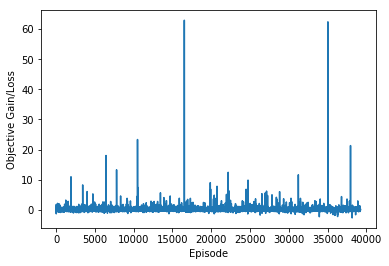

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(policy_loss_value)+1), policy_loss_value)
plt.ylabel('Objective Gain/Loss')
plt.xlabel('Episode')
plt.show()

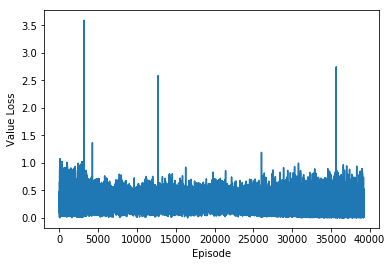

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(value_loss_value)+1), value_loss_value)
plt.ylabel('Value Loss')
plt.xlabel('Episode')
plt.show()

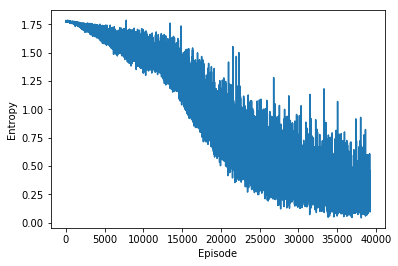

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(entropy_value)+1), entropy_value)
plt.ylabel('Entropy')
plt.xlabel('Episode')
plt.show()

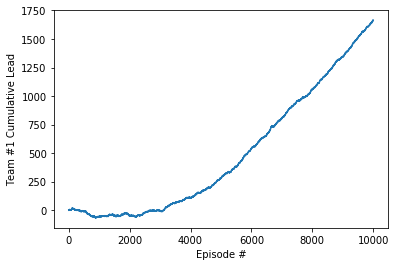

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(team_0_lead)+1), team_0_lead)
plt.ylabel('Team #1 Cumulative Lead')
plt.xlabel('Episode #')
plt.show()

### Watch The Trained Agents

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

striker_0_actor = Actor(s_state_size, s_action_size, hidden_0, hidden_1).to(device)
goalie_0_actor = Actor(g_state_size, g_action_size, hidden_0, hidden_1).to(device)

# Load the saved training parameters
striker_0_actor.load_state_dict(torch.load('checkpoint_striker_0_actor.pth', map_location='cpu'))
goalie_0_actor.load_state_dict(torch.load('checkpoint_goalie_0_actor.pth', map_location='cpu'))

# Set environment to evalulation mode
env_info = env.reset(train_mode=False)        
g_states = env_info[g_brain_name].vector_observations  
s_states = env_info[s_brain_name].vector_observations  

team_0_score = 0
team_1_score = 0
team_0_delta = 0
team_0_lead = []

print("*** Starting the first episode ***")

for i in range(100):

    g_scores = np.zeros(num_g_agents)                      
    s_scores = np.zeros(num_s_agents)           

    while True:
        states_all = combine_states(g_states, s_states)
        g0_prob, g0_action = act(goalie_0_actor, g_states[0])
        s0_prob, s0_action = act(striker_0_actor, s_states[0])
        g_actions = np.array([g0_action, np.random.choice(g_action_size)])
        s_actions = np.array([s0_action, np.random.choice(s_action_size)])
        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))
        env_info = env.step(actions)                       

        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations

        done = np.any(env_info[g_brain_name].local_done)  
        
        #update scores
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        g_scores += g_rewards
        s_scores += s_rewards

        # exit loop if episode finished
        if done:                                           
            break

        # roll over states to next time step
        g_states = g_next_states
        s_states = s_next_states
    
    # calculate team scores and team 0 lead
    team_0_score = round(g_scores[0] + s_scores[0], 2)
    team_1_score = round(g_scores[1] + s_scores[1], 2)
    team_0_delta = round(team_0_score + team_0_delta, 2)
    team_0_lead.append(team_0_delta)
        
    print('Episode {}:\tTrained Team Score: {}      Cumulative Score: {}'.format(i+1, team_0_score, team_0_delta))


*** Starting the first episode ***
Episode 1:	Trained Team Score: 1.1      Cumulative Score: 1.1
Episode 2:	Trained Team Score: 0.0      Cumulative Score: 1.1
Episode 3:	Trained Team Score: -1.1      Cumulative Score: 0.0
Episode 4:	Trained Team Score: 1.1      Cumulative Score: 1.1
Episode 5:	Trained Team Score: -1.1      Cumulative Score: 0.0
Episode 6:	Trained Team Score: -1.1      Cumulative Score: -1.1
Episode 7:	Trained Team Score: 1.1      Cumulative Score: 0.0
Episode 8:	Trained Team Score: 1.1      Cumulative Score: 1.1
Episode 9:	Trained Team Score: 1.1      Cumulative Score: 2.2
Episode 10:	Trained Team Score: 0.0      Cumulative Score: 2.2
Episode 11:	Trained Team Score: 0.0      Cumulative Score: 2.2
Episode 12:	Trained Team Score: -1.1      Cumulative Score: 1.1
Episode 13:	Trained Team Score: 1.1      Cumulative Score: 2.2
Episode 14:	Trained Team Score: 0.0      Cumulative Score: 2.2
Episode 15:	Trained Team Score: 1.1      Cumulative Score: 3.3
Episode 16:	Trained Team

When finished, you can close the environment.

In [ ]:
#env.close()